# Rice disease v.0.3

Huge Kaggle 12G dataset, 3 classes (2 disease + 1 healthy, no Hispa), Modern Architectures

https://www.kaggle.com/minhhuy2810/rice-diseases-image-dataset

## Init

In [1]:
import os
import copy
import time
import shutil
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from collections import Counter
from sklearn.metrics import confusion_matrix
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from torchvision.models import GoogLeNet

torch.autograd.set_detect_anomaly = True

import warnings
warnings.filterwarnings('ignore')

## Params

In [2]:
RANDOM_SEED = 9
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

TRAIN_SIZE = 0.9

In [3]:
avail = torch.cuda.is_available()
print(f'CUDA available: {avail}')
    
if avail:
    print(f'Device: {torch.cuda.get_device_name(torch.cuda.current_device())}')
    print(f'Memory allocated: {torch.cuda.memory_allocated()}')
    print(f'Memory cached:    {torch.cuda.memory_cached()}')
    

DEVICE = torch.device("cuda:0" if avail else "cpu")

CUDA available: True
Device: GeForce GTX 960
Memory allocated: 0
Memory cached:    0


## Utils

In [4]:
def count_parameters(model, verbose=True):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    if verbose:
        for item in params:
            print(f'{item:>8}')
    print(f'________\n{sum(params):>8}')

In [5]:
def show_images(loader, class_names, nrow=5, n_batches=1, figsize=(12,4)):
    # Grab the first batch of 10 images
    images = None
    labels = []
    
    for b, (img, lbl) in enumerate(loader): 
        if n_batches is not None and b >= n_batches:
            break
        
        images = img if images is None else torch.cat((images, img), dim=0)
        labels.extend(lbl.numpy())
        
    labels = np.array(labels).reshape(-1, nrow)
    
    # Print the labels
    print('Labels:\n', labels)
    print('\nClasses:', ' | '.join(np.array([class_names[i] for i in labels[0, :5]])), '...')

    im = make_grid(images, nrow=nrow)  # the default nrow is 8

    # Inverse normalize the images
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    im_inv = inv_normalize(im)

    # Print the images
    plt.figure(figsize=figsize)
    plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)))

In [6]:
def plot_train_report(model, 
                      train_loader, valid_loader,
                      train_losses, valid_losses, train_corrects, valid_corrects, 
                      device):
    
    fig, ax = plt.subplots(1, 3, figsize=(17, 4))
    
    train_len = len(train_loader.sampler.indices)
    valid_len = len(valid_loader.sampler.indices)
    
    ax[0].plot(train_losses, label='training loss')
    ax[0].plot(valid_losses, label='validation loss')
    ax[0].set_title('Loss at the end of each epoch')
    ax[0].grid(True)
    ax[0].legend()

    ax[1].plot([100*t/train_len for t in train_corrects], label='training accuracy')
    ax[1].plot([100*t/valid_len for t in valid_corrects], label='validation accuracy')
    ax[1].set_title('Accuracy at the end of each epoch')
    ax[1].set_ylim((0, 100))
    ax[1].grid(True)
    ax[1].legend()
    
    evaluate_model(model, valid_loader, device, 'Validation', ax=ax[2])

In [7]:
def evaluate_model(model, data_loader, device, mark, ax=None):
    model.eval()
    with torch.no_grad():
        y_evals = []
        y_valids = []

        for X_valid, y_valid in data_loader:
            y_eval = model(X_valid.to(device)).cpu()
            y_evals += list(torch.argmax(y_eval, axis=1).numpy())
            y_valids += list(y_valid.numpy())

    plot_confusion_matrix(y_valids, y_evals, data_loader.dataset.classes, ax=ax)

    print(f'{mark} accuracy:', round((np.array(y_valids) == np.array(y_evals)).sum()*100/len(y_evals), 2), '%')

In [8]:
def plot_confusion_matrix(y_true, y_pred, class_names, ax=None):
    ax = ax or plt.gca()
    
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, class_names, class_names)
    sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn', ax=ax)
    ax.set_xlabel("prediction")
    ax.set_ylabel("label (ground truth)")

In [9]:
def save_progress(epoch, model, optimizer, 
                  train_losses, valid_losses, train_corrects, valid_corrects, 
                  prefix, folder):
    state = {
        'epoch': epoch, 
        'model_state': model.state_dict(), 
        'optimizer_state': optimizer.state_dict(), 
        'train_losses': train_losses, 
        'valid_losses': valid_losses, 
        'train_corrects': train_corrects, 
        'valid_corrects': valid_corrects
    }
    
    torch.save(state, f'{folder}/train_{prefix}.pt')

In [10]:
def restore_progress(model, optimizer,
                     train_losses, valid_losses, train_corrects, valid_corrects,
                     prefix, folder):
    state = torch.load(f'{folder}/train_{prefix}.pt')
    
    model.load_state_dict(state['model_state'])
    optimizer.load_state_dict(state['optimizer_state'])
    
    train_losses.extend(state['train_losses'])
    valid_losses.extend(state['valid_losses'])
    train_corrects.extend(state['train_corrects'])
    valid_corrects.extend(state['valid_corrects'])
    
    return state['epoch']

In [11]:
def augm_images(from_folder, to_folder, pref='_new_'):
    if os.path.exists(to_folder):
        shutil.rmtree(from_folder)
    os.mkdir(to_folder)
    
    for i, file in enumerate(os.listdir(from_folder)):
        fname, ext = os.path.splitext(file)
        fpath = os.path.join(from_folder, file)
        prefix = pref+str(i)
        
        img = Image.open(fpath)
        
        # rotate
        shutil.copyfile(fpath, os.path.join(to_folder, prefix+ext))
        img.transpose(Image.FLIP_LEFT_RIGHT).save(os.path.join(to_folder, prefix+'_flip'+ext))
        img.transpose(Image.FLIP_TOP_BOTTOM).save(os.path.join(to_folder, prefix+'_mirror'+ext))
        
        img.transpose(Image.ROTATE_90).save(os.path.join(to_folder, prefix+'_90'+ext))
        img.transpose(Image.ROTATE_90).transpose(Image.FLIP_LEFT_RIGHT).save(os.path.join(to_folder, prefix+'_90_flip'+ext))
        img.transpose(Image.ROTATE_90).transpose(Image.FLIP_TOP_BOTTOM).save(os.path.join(to_folder, prefix+'_90_mirror'+ext))

        img.transpose(Image.ROTATE_180).save(os.path.join(to_folder, prefix+'_180'+ext))
        img.transpose(Image.ROTATE_180).transpose(Image.FLIP_LEFT_RIGHT).save(os.path.join(to_folder, prefix+'_180_flip'+ext))
        img.transpose(Image.ROTATE_180).transpose(Image.FLIP_TOP_BOTTOM).save(os.path.join(to_folder, prefix+'_180_mirror'+ext))

        img.transpose(Image.ROTATE_270).save(os.path.join(to_folder, prefix+'_270'+ext))
        img.transpose(Image.ROTATE_270).transpose(Image.FLIP_LEFT_RIGHT).save(os.path.join(to_folder, prefix+'_270_flip'+ext))
        img.transpose(Image.ROTATE_270).transpose(Image.FLIP_TOP_BOTTOM).save(os.path.join(to_folder, prefix+'_270_mirror'+ext))

    print('done')

    
def prepare_new_images(data_folder, img_new_folder, img_proc_folder):
    data_new_folder = os.path.join(data_folder, img_new_folder)
    data_proc_folder = os.path.join(data_folder, img_proc_folder)
    if os.path.exists(data_proc_folder):
        shutil.rmtree(data_proc_folder)
    os.mkdir(data_proc_folder)
    
    new_brown_spot = os.path.join(data_new_folder, 'BrownSpot')
    proc_brown_spot = os.path.join(data_proc_folder, 'BrownSpot')
    augm_images(new_brown_spot, proc_brown_spot)
    
    new_leaf_blast = os.path.join(data_new_folder, 'LeafBlast')
    proc_leaf_blast = os.path.join(data_proc_folder, 'LeafBlast')
    augm_images(new_leaf_blast, proc_leaf_blast)

## Data

In [21]:
img_transforms = {
    'train': transforms.Compose([transforms.RandomRotation(30),
                                 transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.RandomVerticalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], 
                                                      [0.229, 0.224, 0.225])]),
    'valid': transforms.Compose([transforms.Resize(224),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], 
                                                      [0.229, 0.224, 0.225])])
}

In [19]:
data_folder = '/home/sergey-msu/Work/startup/data/kaggle12Gb/LabelledRice/Labelled_ext'
data_new_folder = '/home/sergey-msu/Work/startup/data/kaggle12Gb/LabelledRice/Labelled_new'

In [17]:
all_data = datasets.ImageFolder(data_folder)
img_counts = Counter([img[1] for img in all_data.imgs])
cls_counts = {k:img_counts[i] for k,i in all_data.class_to_idx.items()}

In [18]:
print(all_data.class_to_idx)
print(cls_counts)
print('Total: ', len(all_data))

print('\nInitial stratification:')
print({cls : f'{round(100*cnt/len(all_data), 2)}%' for cls,cnt in cls_counts.items()})

{'BrownSpot': 0, 'Healthy': 1, 'LeafBlast': 2}
{'BrownSpot': 1195, 'Healthy': 1488, 'LeafBlast': 1595}
Total:  4278

Initial stratification:
{'BrownSpot': '27.93%', 'Healthy': '34.78%', 'LeafBlast': '37.28%'}


In [19]:
all_cls = np.array([img[1] for img in all_data.imgs])
idx_to_class = np.array([[i, img] for i, img in enumerate(all_cls)])
np.random.shuffle(idx_to_class)

In [20]:
train_idx = []
valid_idx = []

class_idx = list(all_data.class_to_idx.values())
for i in class_idx:
    class_items = idx_to_class[idx_to_class[:, 1] == i][:, 0]
    train_len = int(len(class_items)*TRAIN_SIZE)
    
    train_idx += list(class_items[:train_len])
    valid_idx += list(class_items[train_len:])

assert set(train_idx) | set(valid_idx) == set(range(len(all_data)))

In [21]:
# ensure stratification
print('Initial stratification:')
print({cls : f'{round(100*cnt/len(all_cls), 2)}%' for (cls, cnt) in Counter(all_cls).items()})

print('\nTrain stratification:')
train_cls = all_cls[train_idx]
print({cls : f'{round(100*cnt/len(train_cls), 2)}%' for (cls, cnt) in Counter(train_cls).items()})

print('\nValidation stratification:')
valid_cls = all_cls[valid_idx]
print({cls : f'{round(100*cnt/len(valid_cls), 2)}%' for (cls, cnt) in Counter(valid_cls).items()})

Initial stratification:
{0: '27.93%', 1: '34.78%', 2: '37.28%'}

Train stratification:
{0: '27.93%', 1: '34.79%', 2: '37.28%'}

Validation stratification:
{0: '27.97%', 1: '34.73%', 2: '37.3%'}


In [22]:
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [23]:
train_loader = DataLoader(datasets.ImageFolder(data_folder, transform=img_transforms['train']), 
                          batch_size=10, 
                          sampler=train_sampler,
                          pin_memory=False,
                          num_workers=4)
valid_loader = DataLoader(datasets.ImageFolder(data_folder, transform=img_transforms['valid']), 
                          batch_size=100, 
                          sampler=valid_sampler,
                          pin_memory=False,
                          num_workers=4)
valid_new_loader = DataLoader(datasets.ImageFolder(data_new_folder, transform=img_transforms['valid']), 
                          batch_size=100,
                          pin_memory=False,
                          num_workers=4)

## Load Model

In [25]:
state = torch.load('')
state_version = state['version']
print(state_version)
model_state = state['model_state']


model_ = GoogLeNet(transform_input=True, 
                   aux_logits=False, 
                   init_weights=False)
n_inputs = model_.fc.in_features
model_.fc = nn.Linear(n_inputs, 3)
model_.load_state_dict(model_state)

model_ = model_.to(DEVICE)

0.1


New Eval accuracy: 63.09 %


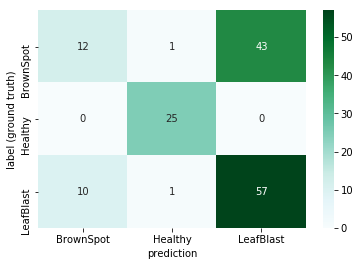

In [26]:
evaluate_model(model_, valid_new_loader, DEVICE, 'New Eval')

In [42]:
state = torch.load('')

model__ = GoogLeNet(transform_input=True, 
                    aux_logits=False, 
                    init_weights=False)
n_inputs = model__.fc.in_features
model__.fc = nn.Linear(n_inputs, 3)
model__.load_state_dict(state['model_state'])

model__ = model__.to(DEVICE)

New Eval accuracy: 100.0 %


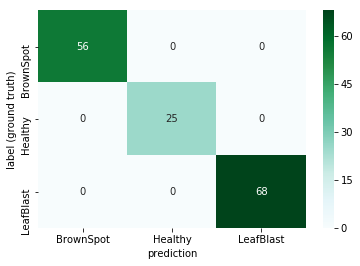

In [43]:
evaluate_model(model__, valid_new_loader, DEVICE, 'New Eval')

## Train

In [27]:
def train(model, criterion, optimizer, 
          train_loader, valid_loader, 
          n_epoch, device,
          out_train_losses,
          out_valid_losses,
          out_train_corrects,
          out_valid_corrects,
          out_best_model_prefix,
          prefix
         ):
    start_time = time.time()

    train_len = len(train_loader.sampler.indices)
    valid_len = len(valid_loader.sampler.indices)
    n_train_batches = int(train_len/train_loader.batch_size)
    n_valid_batches = int(valid_len/valid_loader.batch_size)
    best_valid_accuracy = 0
    
    print('Begin...')
    
    for i in range(n_epoch):
        
        # train
        
        model.train()
        
        train_correct = 0
        
        for b, (X_train, y_train) in enumerate(train_loader):
            X_train = X_train.to(device)
            y_train = y_train.to(device)
            optimizer.zero_grad()
            
            y_pred = model(X_train)
            loss = criterion(y_pred, y_train)
            loss.backward()
            optimizer.step()

            y_pred = torch.max(y_pred, dim=1)[1]
            train_correct += (y_pred == y_train).sum()
            
            if b%100 == 0:
                print(f'---- batch: {b}({n_train_batches})')
            
        loss_val = round(float(loss), 2)
        correct_pct = round(train_correct.item()*100/train_len, 2)
        print(f'Epoch: {i+1}\tTRAIN\tLoss: {loss_val}\tCorrect: {train_correct}/{train_len}({correct_pct}%)')
    
        out_train_losses.append(loss_val)
        out_train_corrects.append(train_correct)
        
        # validation
        
        model.eval()
        
        valid_correct = 0
        y_evals = []
        y_valids = []
        
        with torch.no_grad():
            for b, (X_valid, y_valid) in enumerate(valid_loader):
                X_valid = X_valid.to(device)
                y_valid = y_valid.to(device)
                y_eval = model(X_valid)
                loss = criterion(y_eval, y_valid)
                
                y_eval = torch.max(y_eval, dim=1)[1]
                valid_correct += (y_eval == y_valid).sum()
                y_evals += list(y_eval.cpu().view(-1))
                y_valids += list(y_valid.cpu().view(-1))
            
        loss_val = round(float(loss), 2)
        correct_pct = round(valid_correct.item()*100/valid_len, 2)
        print(f'\t\tVALID.:\tLoss: {loss_val}\tCorrect: {valid_correct}/{valid_len}({correct_pct}%)')
    
        out_valid_losses.append(loss_val)
        out_valid_corrects.append(valid_correct)
        
        # plot results
        plot_confusion_matrix(y_valids, y_evals, train_loader.dataset.classes)
        plt.show()
        
        # save results
        if (i+1)%50==0:
            save_progress(i+1, 
                          model, optimizer, 
                          out_train_losses, out_valid_losses, out_train_corrects, out_valid_corrects, 
                          f'{prefix}_e{i+1}', 'progress')

        # save the best
        if correct_pct > best_valid_accuracy:
            best_valid_accuracy = correct_pct
            best_model_prefix = f'{prefix}_e{i+1}_best{correct_pct}'
            out_best_model_prefix[0] = best_model_prefix
            save_progress(i+1,
                          model, optimizer, 
                          out_train_losses, out_valid_losses, out_train_corrects, out_valid_corrects, 
                          best_model_prefix, 'progress')
            
            print('\tBest validation accuracy:', best_valid_accuracy)
        print('\n----------------------------------------\n')

    end_time = time.time()
    print(f'End.\nDuration: {time.time() - start_time:.0f} seconds')
    
    return best_model_prefix

## GoogleNet

In [28]:
model_googlenet = models.googlenet(pretrained=True)

In [29]:
count_parameters(model_googlenet, verbose=False)

________
 6624904


In [30]:
next(model_googlenet.parameters()).is_cuda

False

In [31]:
for param in model_googlenet.parameters():
    param.requires_grad=True

In [32]:
n_inputs = model_googlenet.fc.in_features
model_googlenet.fc = nn.Linear(n_inputs, 3)
model_googlenet = model_googlenet.to(DEVICE)

count_parameters(model_googlenet, verbose=False)

________
 5602979


In [33]:
optimizer = torch.optim.Adam(model_googlenet.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [34]:
train_losses = []
valid_losses = []
train_corrects = []
valid_corrects = []

Begin...
---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 1	TRAIN	Loss: 1.2	Correct: 3211/3849(83.42%)
		VALID.:	Loss: 0.62	Correct: 336/429(78.32%)


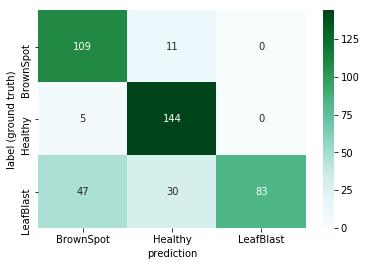

	Best validation accuracy: 78.32

----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 2	TRAIN	Loss: 0.35	Correct: 3224/3849(83.76%)
		VALID.:	Loss: 0.71	Correct: 370/429(86.25%)


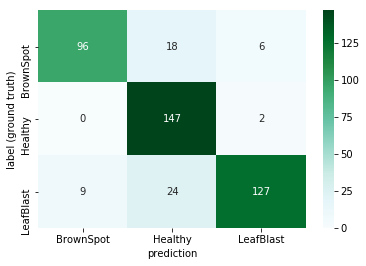

	Best validation accuracy: 86.25

----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 3	TRAIN	Loss: 0.48	Correct: 3215/3849(83.53%)
		VALID.:	Loss: 0.37	Correct: 376/429(87.65%)


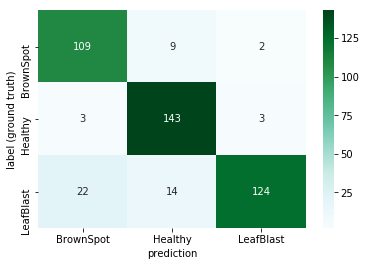

	Best validation accuracy: 87.65

----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 4	TRAIN	Loss: 0.06	Correct: 3249/3849(84.41%)
		VALID.:	Loss: 0.42	Correct: 373/429(86.95%)


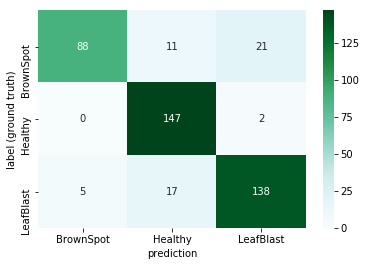


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 5	TRAIN	Loss: 0.67	Correct: 3225/3849(83.79%)
		VALID.:	Loss: 0.2	Correct: 383/429(89.28%)


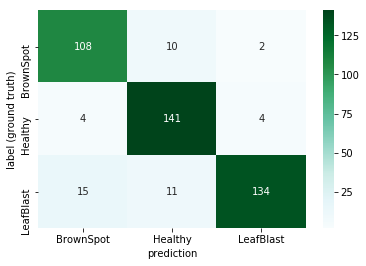

	Best validation accuracy: 89.28

----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 6	TRAIN	Loss: 0.39	Correct: 3240/3849(84.18%)
		VALID.:	Loss: 0.24	Correct: 364/429(84.85%)


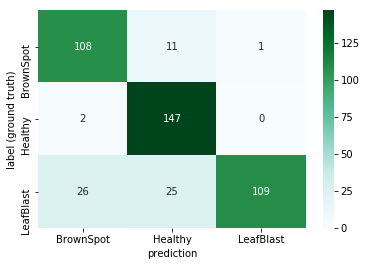


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 7	TRAIN	Loss: 0.73	Correct: 3237/3849(84.1%)
		VALID.:	Loss: 0.25	Correct: 374/429(87.18%)


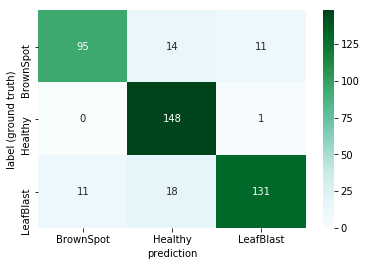


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 8	TRAIN	Loss: 0.59	Correct: 3270/3849(84.96%)
		VALID.:	Loss: 0.19	Correct: 379/429(88.34%)


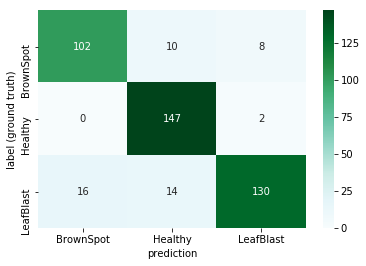


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 9	TRAIN	Loss: 0.92	Correct: 3235/3849(84.05%)
		VALID.:	Loss: 0.55	Correct: 378/429(88.11%)


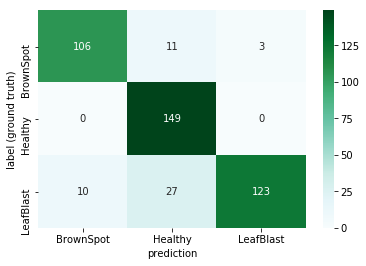


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 10	TRAIN	Loss: 0.19	Correct: 3299/3849(85.71%)
		VALID.:	Loss: 0.33	Correct: 379/429(88.34%)


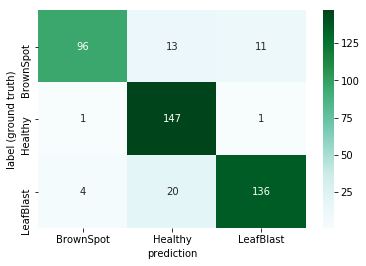


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 11	TRAIN	Loss: 0.51	Correct: 3257/3849(84.62%)
		VALID.:	Loss: 0.3	Correct: 378/429(88.11%)


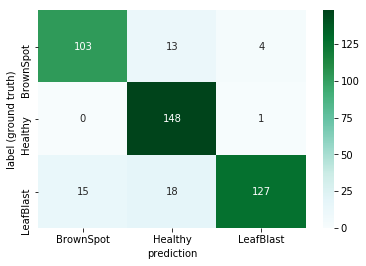


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 12	TRAIN	Loss: 0.45	Correct: 3279/3849(85.19%)
		VALID.:	Loss: 0.29	Correct: 376/429(87.65%)


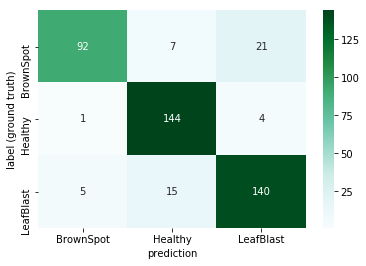


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 13	TRAIN	Loss: 0.3	Correct: 3319/3849(86.23%)
		VALID.:	Loss: 0.41	Correct: 384/429(89.51%)


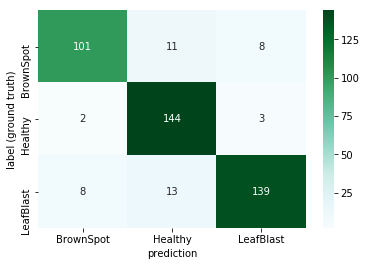

	Best validation accuracy: 89.51

----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 14	TRAIN	Loss: 0.33	Correct: 3304/3849(85.84%)
		VALID.:	Loss: 0.32	Correct: 372/429(86.71%)


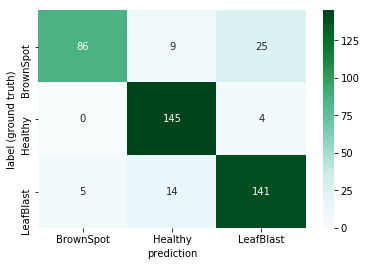


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 15	TRAIN	Loss: 0.25	Correct: 3308/3849(85.94%)
		VALID.:	Loss: 0.49	Correct: 385/429(89.74%)


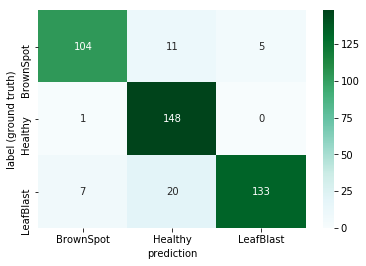

	Best validation accuracy: 89.74

----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 16	TRAIN	Loss: 0.36	Correct: 3289/3849(85.45%)
		VALID.:	Loss: 0.44	Correct: 379/429(88.34%)


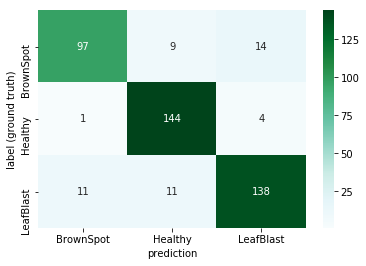


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 17	TRAIN	Loss: 0.37	Correct: 3328/3849(86.46%)
		VALID.:	Loss: 0.29	Correct: 389/429(90.68%)


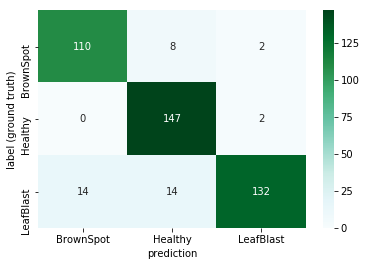

	Best validation accuracy: 90.68

----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 18	TRAIN	Loss: 0.48	Correct: 3311/3849(86.02%)
		VALID.:	Loss: 0.24	Correct: 381/429(88.81%)


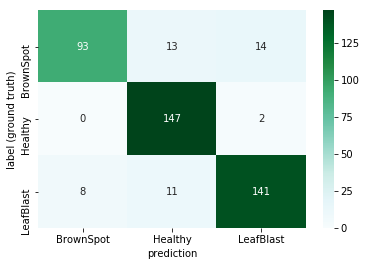


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 19	TRAIN	Loss: 0.56	Correct: 3297/3849(85.66%)
		VALID.:	Loss: 0.49	Correct: 381/429(88.81%)


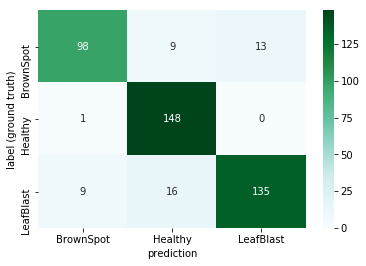


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 20	TRAIN	Loss: 0.5	Correct: 3345/3849(86.91%)
		VALID.:	Loss: 0.18	Correct: 376/429(87.65%)


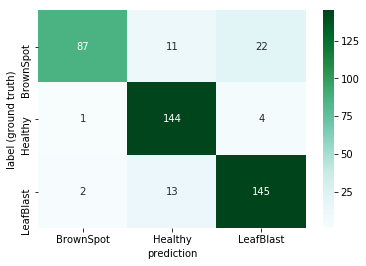


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 21	TRAIN	Loss: 0.17	Correct: 3346/3849(86.93%)
		VALID.:	Loss: 0.46	Correct: 374/429(87.18%)


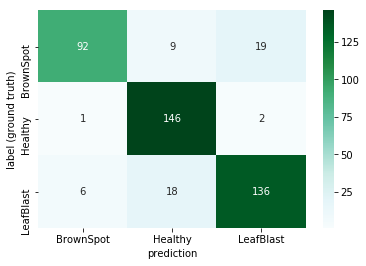


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 22	TRAIN	Loss: 0.65	Correct: 3356/3849(87.19%)
		VALID.:	Loss: 0.38	Correct: 382/429(89.04%)


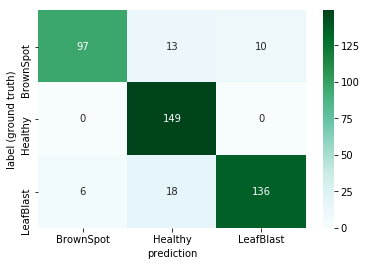


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 23	TRAIN	Loss: 0.24	Correct: 3365/3849(87.43%)
		VALID.:	Loss: 0.28	Correct: 384/429(89.51%)


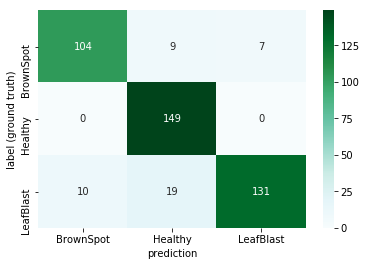


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 24	TRAIN	Loss: 0.2	Correct: 3364/3849(87.4%)
		VALID.:	Loss: 0.24	Correct: 387/429(90.21%)


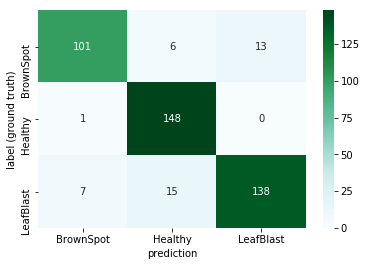


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 25	TRAIN	Loss: 0.15	Correct: 3381/3849(87.84%)
		VALID.:	Loss: 0.24	Correct: 390/429(90.91%)


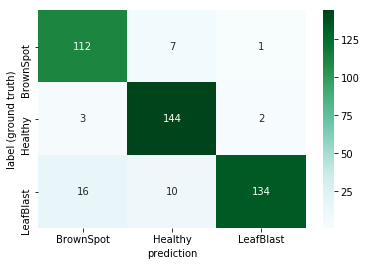

	Best validation accuracy: 90.91

----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 26	TRAIN	Loss: 0.12	Correct: 3329/3849(86.49%)
		VALID.:	Loss: 0.24	Correct: 379/429(88.34%)


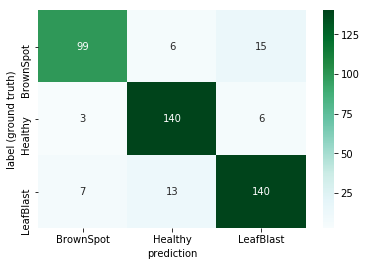


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 27	TRAIN	Loss: 0.54	Correct: 3355/3849(87.17%)
		VALID.:	Loss: 0.41	Correct: 383/429(89.28%)


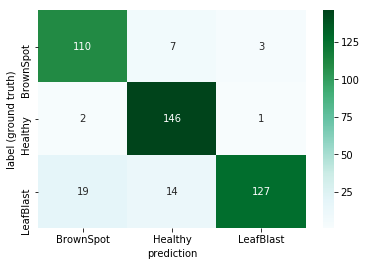


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 28	TRAIN	Loss: 0.17	Correct: 3354/3849(87.14%)
		VALID.:	Loss: 0.29	Correct: 400/429(93.24%)


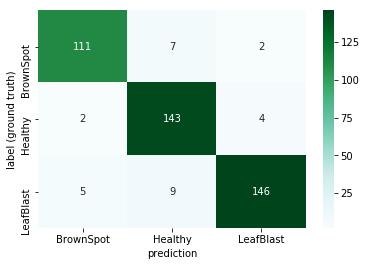

	Best validation accuracy: 93.24

----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 29	TRAIN	Loss: 0.21	Correct: 3376/3849(87.71%)
		VALID.:	Loss: 0.27	Correct: 382/429(89.04%)


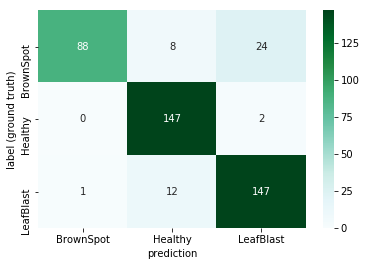


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 30	TRAIN	Loss: 0.37	Correct: 3366/3849(87.45%)
		VALID.:	Loss: 0.33	Correct: 380/429(88.58%)


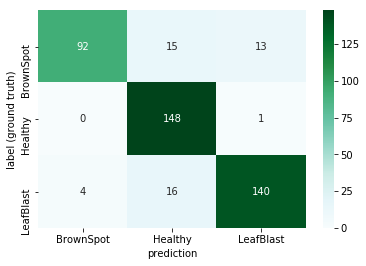


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 31	TRAIN	Loss: 0.11	Correct: 3386/3849(87.97%)
		VALID.:	Loss: 0.3	Correct: 389/429(90.68%)


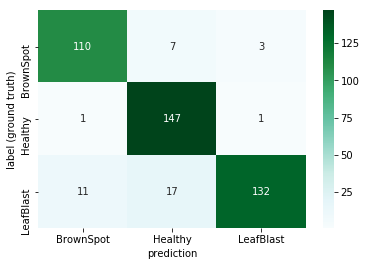


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 32	TRAIN	Loss: 0.1	Correct: 3381/3849(87.84%)
		VALID.:	Loss: 0.18	Correct: 377/429(87.88%)


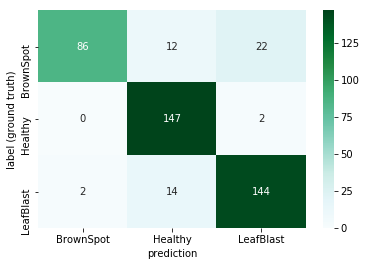


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 33	TRAIN	Loss: 0.36	Correct: 3373/3849(87.63%)
		VALID.:	Loss: 0.31	Correct: 391/429(91.14%)


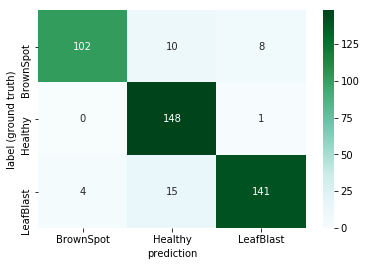


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 34	TRAIN	Loss: 0.56	Correct: 3366/3849(87.45%)
		VALID.:	Loss: 0.18	Correct: 395/429(92.07%)


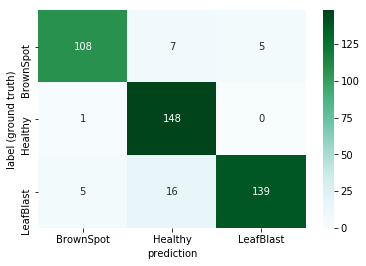


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 35	TRAIN	Loss: 0.63	Correct: 3390/3849(88.07%)
		VALID.:	Loss: 0.59	Correct: 390/429(90.91%)


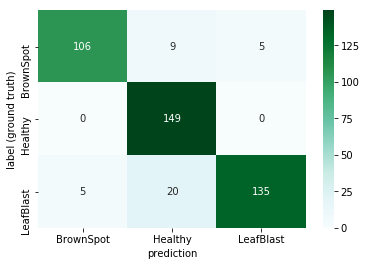


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 36	TRAIN	Loss: 0.36	Correct: 3385/3849(87.94%)
		VALID.:	Loss: 0.23	Correct: 388/429(90.44%)


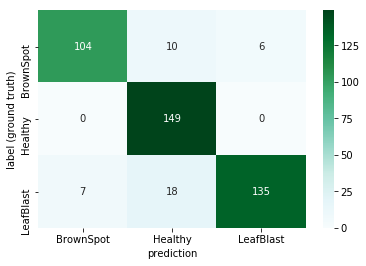


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 37	TRAIN	Loss: 0.2	Correct: 3366/3849(87.45%)
		VALID.:	Loss: 0.1	Correct: 389/429(90.68%)


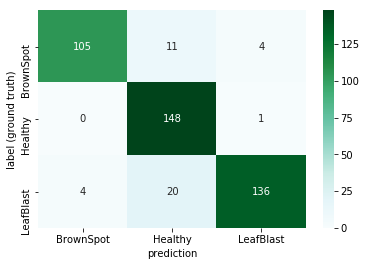


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 38	TRAIN	Loss: 0.9	Correct: 3393/3849(88.15%)
		VALID.:	Loss: 0.28	Correct: 384/429(89.51%)


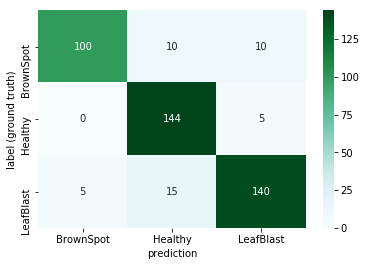


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 39	TRAIN	Loss: 0.57	Correct: 3397/3849(88.26%)
		VALID.:	Loss: 0.26	Correct: 389/429(90.68%)


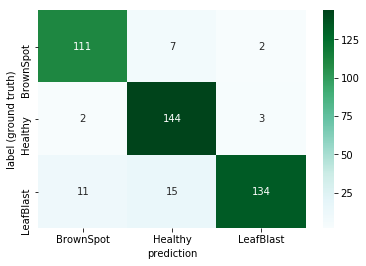


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 40	TRAIN	Loss: 0.39	Correct: 3376/3849(87.71%)
		VALID.:	Loss: 0.14	Correct: 390/429(90.91%)


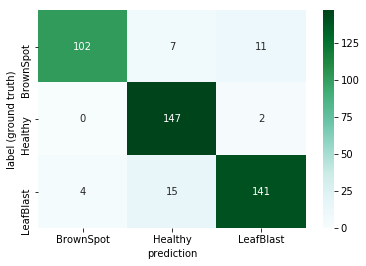


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 41	TRAIN	Loss: 0.12	Correct: 3416/3849(88.75%)
		VALID.:	Loss: 0.15	Correct: 385/429(89.74%)


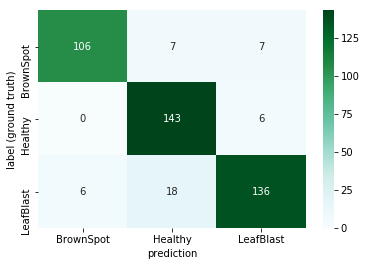


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 42	TRAIN	Loss: 0.61	Correct: 3417/3849(88.78%)
		VALID.:	Loss: 0.64	Correct: 387/429(90.21%)


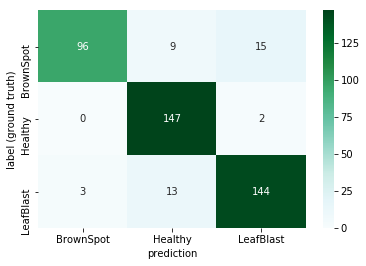


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 43	TRAIN	Loss: 0.5	Correct: 3400/3849(88.33%)
		VALID.:	Loss: 0.45	Correct: 386/429(89.98%)


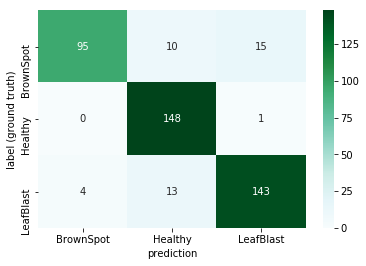


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 44	TRAIN	Loss: 0.22	Correct: 3435/3849(89.24%)
		VALID.:	Loss: 0.13	Correct: 392/429(91.38%)


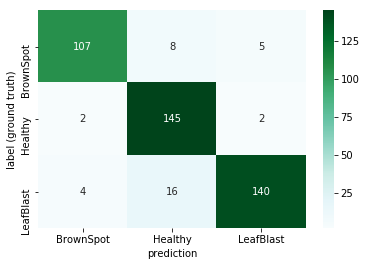


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 45	TRAIN	Loss: 0.32	Correct: 3409/3849(88.57%)
		VALID.:	Loss: 0.25	Correct: 393/429(91.61%)


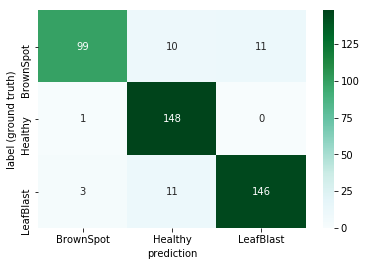


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 46	TRAIN	Loss: 0.4	Correct: 3413/3849(88.67%)
		VALID.:	Loss: 0.23	Correct: 379/429(88.34%)


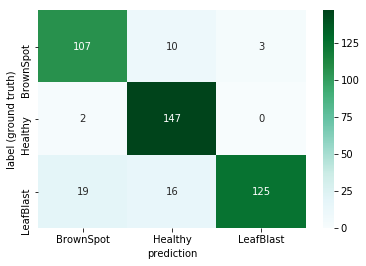


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 47	TRAIN	Loss: 0.11	Correct: 3417/3849(88.78%)
		VALID.:	Loss: 0.33	Correct: 393/429(91.61%)


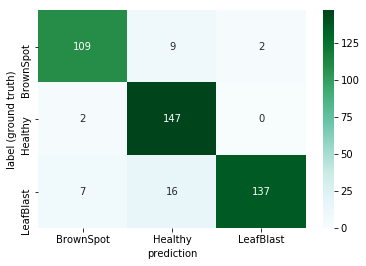


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 48	TRAIN	Loss: 0.4	Correct: 3421/3849(88.88%)
		VALID.:	Loss: 0.25	Correct: 393/429(91.61%)


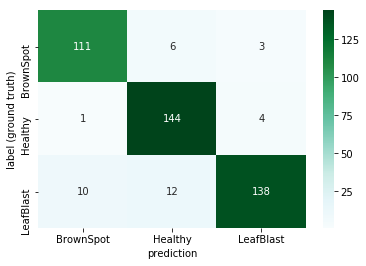


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 49	TRAIN	Loss: 0.19	Correct: 3418/3849(88.8%)
		VALID.:	Loss: 0.27	Correct: 387/429(90.21%)


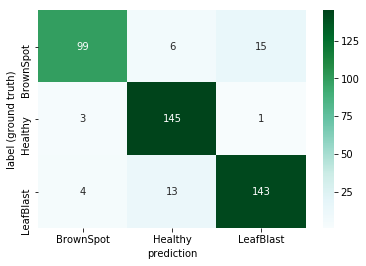


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 50	TRAIN	Loss: 0.12	Correct: 3425/3849(88.98%)
		VALID.:	Loss: 0.18	Correct: 392/429(91.38%)


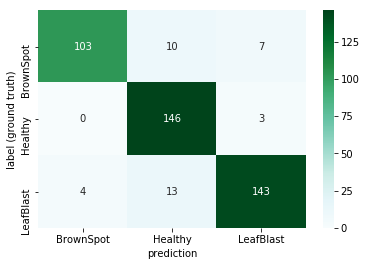


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 51	TRAIN	Loss: 0.41	Correct: 3399/3849(88.31%)
		VALID.:	Loss: 0.05	Correct: 390/429(90.91%)


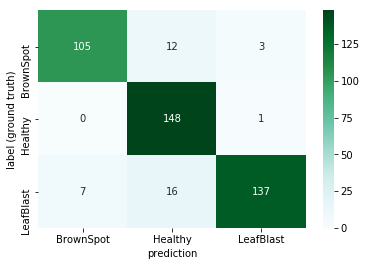


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 52	TRAIN	Loss: 0.06	Correct: 3428/3849(89.06%)
		VALID.:	Loss: 0.19	Correct: 397/429(92.54%)


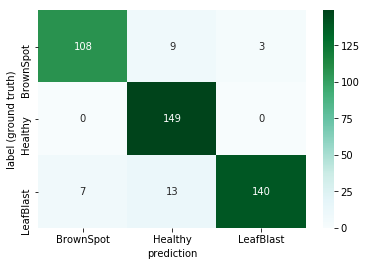


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 53	TRAIN	Loss: 0.45	Correct: 3451/3849(89.66%)
		VALID.:	Loss: 0.36	Correct: 393/429(91.61%)


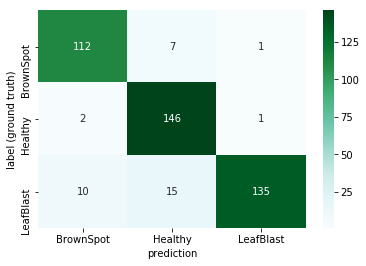


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 54	TRAIN	Loss: 0.5	Correct: 3415/3849(88.72%)
		VALID.:	Loss: 0.2	Correct: 394/429(91.84%)


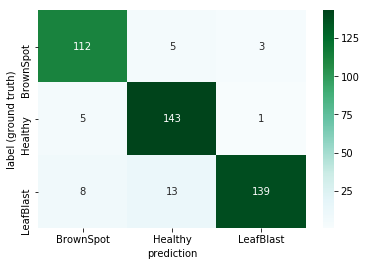


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 55	TRAIN	Loss: 0.1	Correct: 3403/3849(88.41%)
		VALID.:	Loss: 0.17	Correct: 388/429(90.44%)


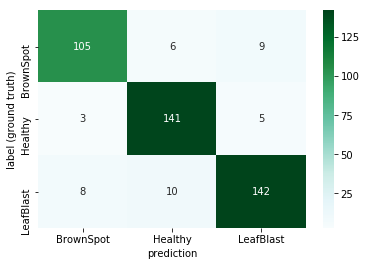


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 56	TRAIN	Loss: 0.14	Correct: 3419/3849(88.83%)
		VALID.:	Loss: 0.08	Correct: 397/429(92.54%)


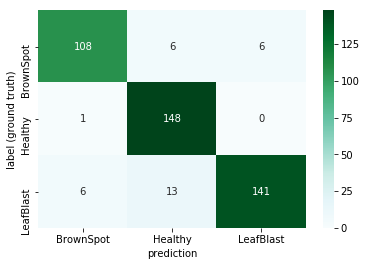


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 57	TRAIN	Loss: 0.43	Correct: 3433/3849(89.19%)
		VALID.:	Loss: 0.28	Correct: 388/429(90.44%)


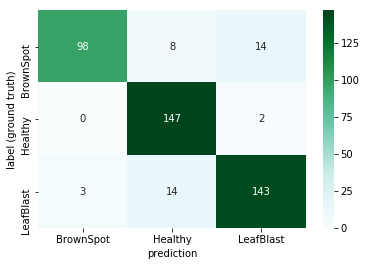


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 58	TRAIN	Loss: 0.73	Correct: 3444/3849(89.48%)
		VALID.:	Loss: 0.24	Correct: 391/429(91.14%)


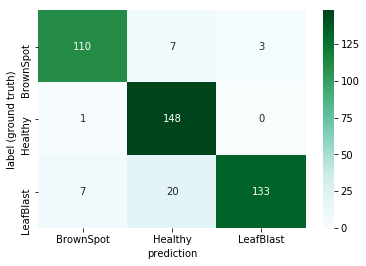


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 59	TRAIN	Loss: 0.11	Correct: 3440/3849(89.37%)
		VALID.:	Loss: 0.29	Correct: 392/429(91.38%)


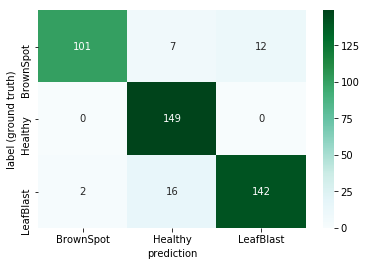


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 60	TRAIN	Loss: 0.36	Correct: 3438/3849(89.32%)
		VALID.:	Loss: 0.23	Correct: 397/429(92.54%)


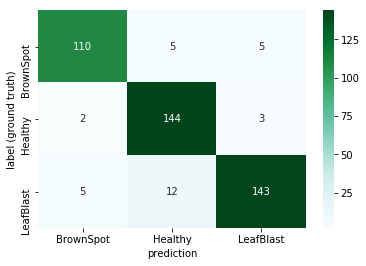


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 61	TRAIN	Loss: 0.11	Correct: 3422/3849(88.91%)
		VALID.:	Loss: 0.07	Correct: 399/429(93.01%)


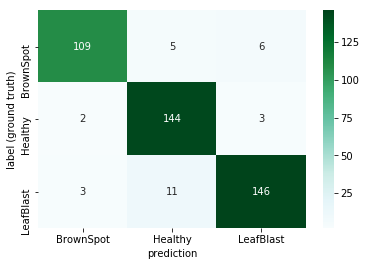


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 62	TRAIN	Loss: 0.25	Correct: 3393/3849(88.15%)
		VALID.:	Loss: 0.43	Correct: 390/429(90.91%)


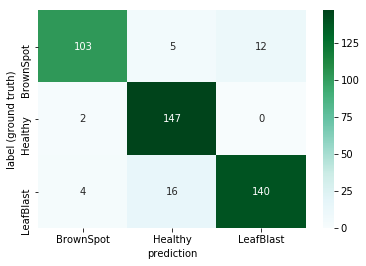


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 63	TRAIN	Loss: 0.09	Correct: 3399/3849(88.31%)
		VALID.:	Loss: 0.18	Correct: 398/429(92.77%)


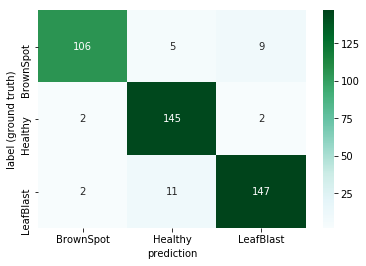


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 64	TRAIN	Loss: 0.36	Correct: 3439/3849(89.35%)
		VALID.:	Loss: 0.06	Correct: 399/429(93.01%)


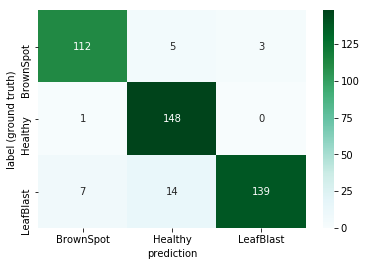


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 65	TRAIN	Loss: 0.11	Correct: 3446/3849(89.53%)
		VALID.:	Loss: 0.11	Correct: 396/429(92.31%)


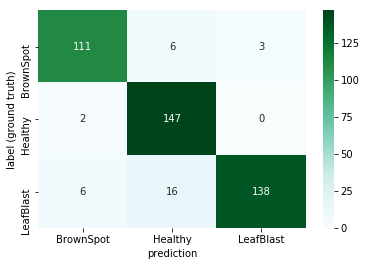


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 66	TRAIN	Loss: 0.12	Correct: 3448/3849(89.58%)
		VALID.:	Loss: 0.19	Correct: 394/429(91.84%)


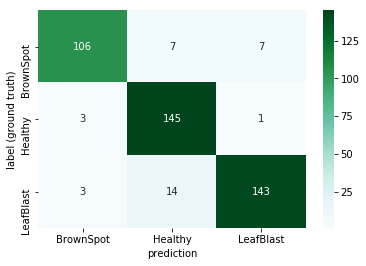


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 67	TRAIN	Loss: 0.09	Correct: 3455/3849(89.76%)
		VALID.:	Loss: 0.29	Correct: 396/429(92.31%)


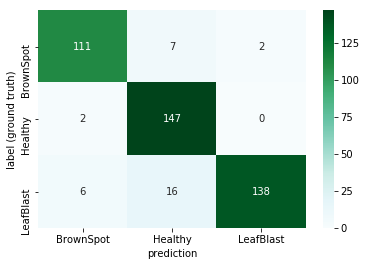


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 68	TRAIN	Loss: 0.14	Correct: 3436/3849(89.27%)
		VALID.:	Loss: 0.34	Correct: 392/429(91.38%)


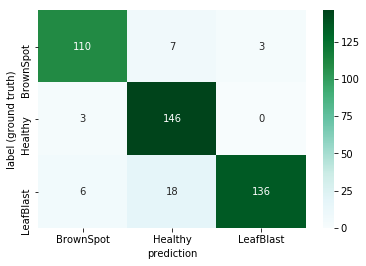


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 69	TRAIN	Loss: 0.5	Correct: 3420/3849(88.85%)
		VALID.:	Loss: 0.17	Correct: 396/429(92.31%)


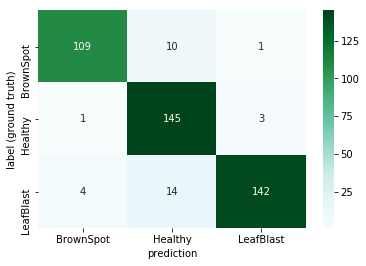


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 70	TRAIN	Loss: 0.55	Correct: 3464/3849(90.0%)
		VALID.:	Loss: 0.4	Correct: 397/429(92.54%)


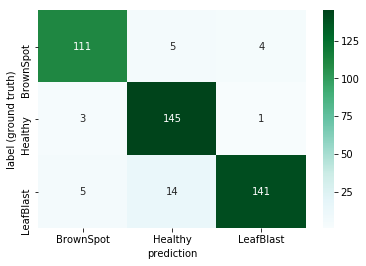


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 71	TRAIN	Loss: 0.07	Correct: 3455/3849(89.76%)
		VALID.:	Loss: 0.23	Correct: 400/429(93.24%)


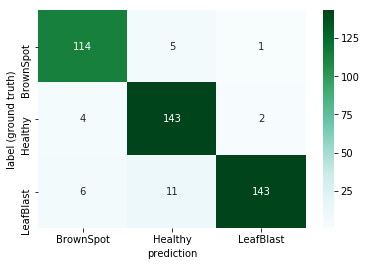


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 72	TRAIN	Loss: 0.37	Correct: 3435/3849(89.24%)
		VALID.:	Loss: 0.38	Correct: 397/429(92.54%)


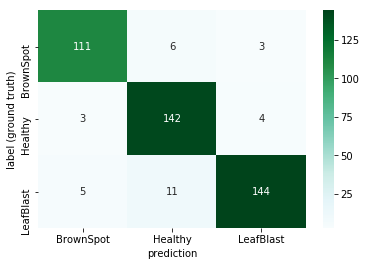


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 73	TRAIN	Loss: 0.81	Correct: 3403/3849(88.41%)
		VALID.:	Loss: 0.3	Correct: 384/429(89.51%)


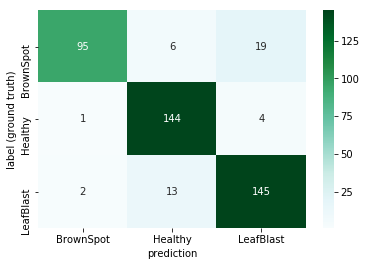


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 74	TRAIN	Loss: 0.06	Correct: 3493/3849(90.75%)
		VALID.:	Loss: 0.11	Correct: 403/429(93.94%)


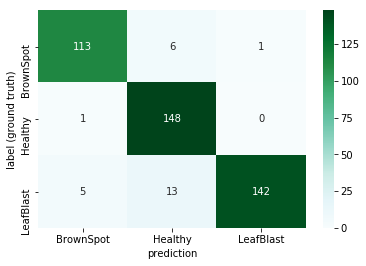

	Best validation accuracy: 93.94

----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 75	TRAIN	Loss: 0.08	Correct: 3474/3849(90.26%)
		VALID.:	Loss: 0.35	Correct: 383/429(89.28%)


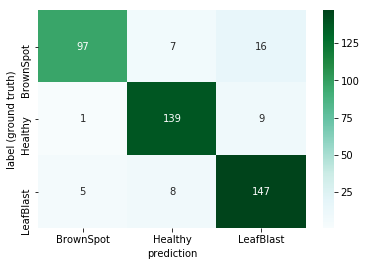


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 76	TRAIN	Loss: 0.09	Correct: 3472/3849(90.21%)
		VALID.:	Loss: 0.36	Correct: 396/429(92.31%)


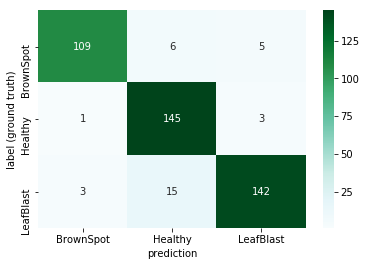


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 77	TRAIN	Loss: 0.12	Correct: 3475/3849(90.28%)
		VALID.:	Loss: 0.17	Correct: 397/429(92.54%)


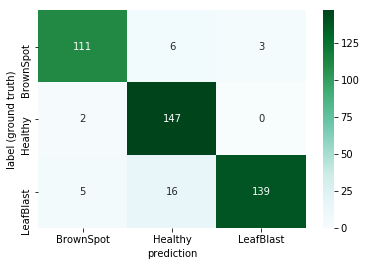


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 78	TRAIN	Loss: 0.08	Correct: 3451/3849(89.66%)
		VALID.:	Loss: 0.49	Correct: 394/429(91.84%)


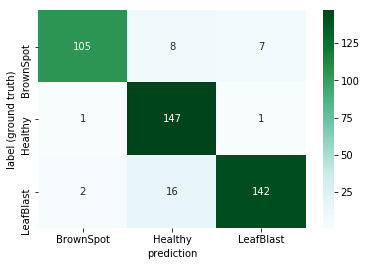


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 79	TRAIN	Loss: 0.13	Correct: 3461/3849(89.92%)
		VALID.:	Loss: 0.11	Correct: 396/429(92.31%)


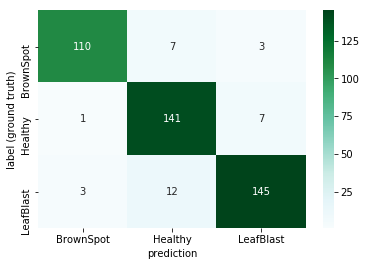


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 80	TRAIN	Loss: 0.2	Correct: 3484/3849(90.52%)
		VALID.:	Loss: 0.33	Correct: 394/429(91.84%)


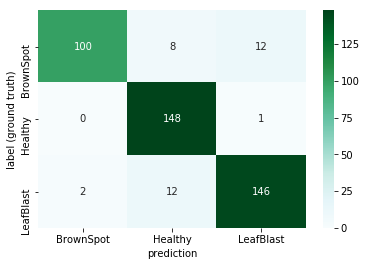


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 81	TRAIN	Loss: 0.84	Correct: 3456/3849(89.79%)
		VALID.:	Loss: 0.29	Correct: 397/429(92.54%)


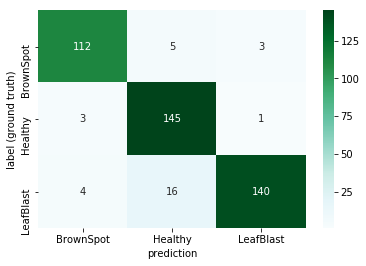


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 82	TRAIN	Loss: 0.18	Correct: 3452/3849(89.69%)
		VALID.:	Loss: 0.07	Correct: 399/429(93.01%)


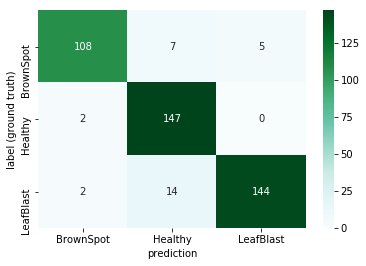


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 83	TRAIN	Loss: 0.04	Correct: 3486/3849(90.57%)
		VALID.:	Loss: 0.25	Correct: 401/429(93.47%)


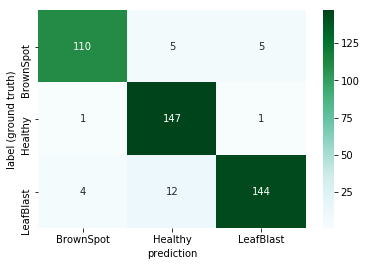


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 84	TRAIN	Loss: 0.18	Correct: 3445/3849(89.5%)
		VALID.:	Loss: 0.13	Correct: 394/429(91.84%)


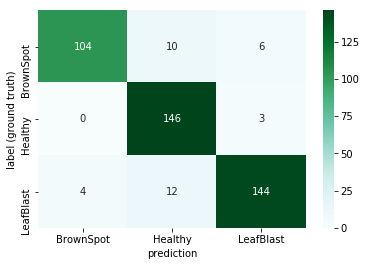


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 85	TRAIN	Loss: 0.16	Correct: 3467/3849(90.08%)
		VALID.:	Loss: 0.07	Correct: 399/429(93.01%)


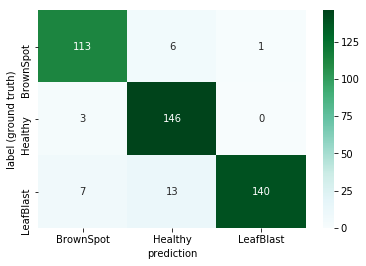


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 86	TRAIN	Loss: 0.37	Correct: 3465/3849(90.02%)
		VALID.:	Loss: 0.2	Correct: 392/429(91.38%)


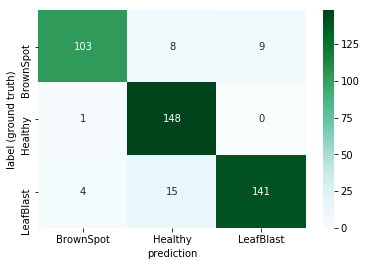


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 87	TRAIN	Loss: 0.64	Correct: 3439/3849(89.35%)
		VALID.:	Loss: 0.1	Correct: 403/429(93.94%)


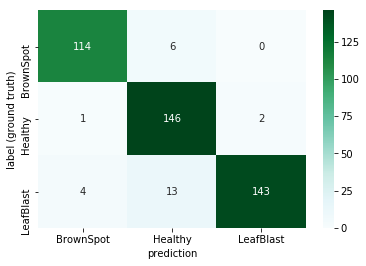


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 88	TRAIN	Loss: 0.77	Correct: 3462/3849(89.95%)
		VALID.:	Loss: 0.06	Correct: 401/429(93.47%)


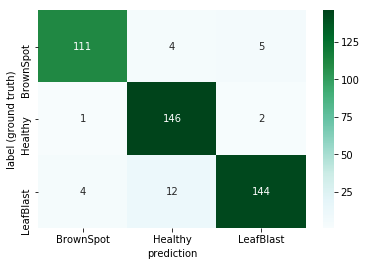


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 89	TRAIN	Loss: 0.16	Correct: 3492/3849(90.72%)
		VALID.:	Loss: 0.18	Correct: 399/429(93.01%)


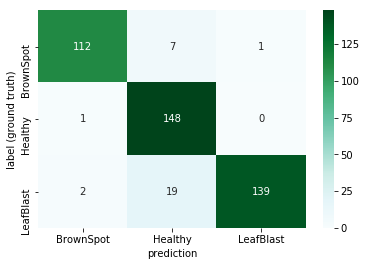


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 90	TRAIN	Loss: 0.19	Correct: 3478/3849(90.36%)
		VALID.:	Loss: 0.35	Correct: 402/429(93.71%)


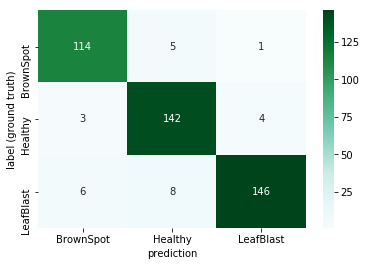


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 91	TRAIN	Loss: 0.97	Correct: 3489/3849(90.65%)
		VALID.:	Loss: 0.13	Correct: 395/429(92.07%)


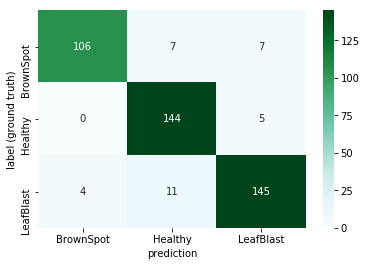


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 92	TRAIN	Loss: 0.02	Correct: 3447/3849(89.56%)
		VALID.:	Loss: 0.12	Correct: 398/429(92.77%)


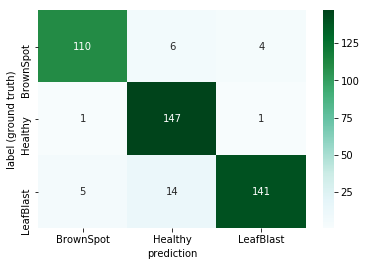


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 93	TRAIN	Loss: 0.63	Correct: 3461/3849(89.92%)
		VALID.:	Loss: 0.17	Correct: 394/429(91.84%)


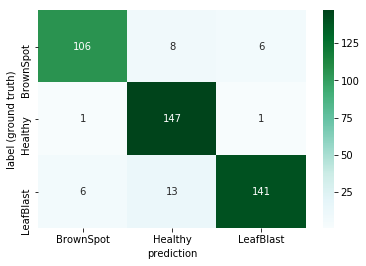


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 94	TRAIN	Loss: 0.15	Correct: 3468/3849(90.1%)
		VALID.:	Loss: 0.15	Correct: 393/429(91.61%)


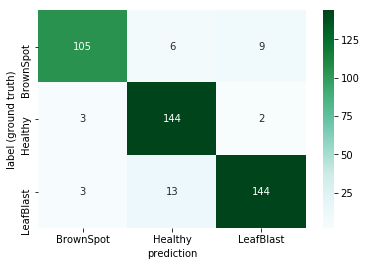


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 95	TRAIN	Loss: 0.39	Correct: 3462/3849(89.95%)
		VALID.:	Loss: 0.13	Correct: 397/429(92.54%)


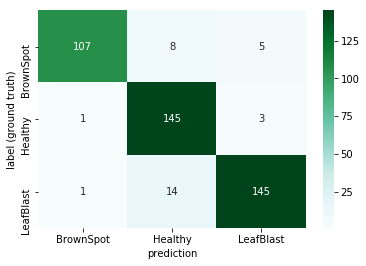


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 96	TRAIN	Loss: 0.46	Correct: 3467/3849(90.08%)
		VALID.:	Loss: 0.2	Correct: 392/429(91.38%)


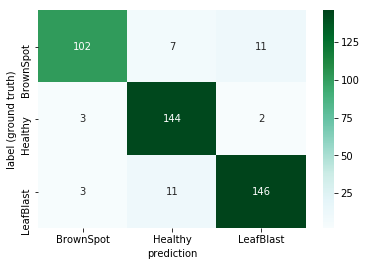


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 97	TRAIN	Loss: 0.18	Correct: 3469/3849(90.13%)
		VALID.:	Loss: 0.29	Correct: 385/429(89.74%)


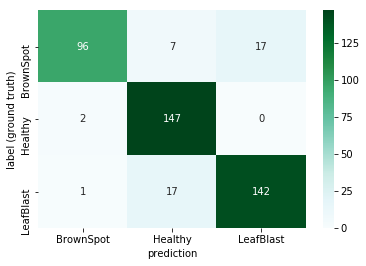


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 98	TRAIN	Loss: 0.23	Correct: 3494/3849(90.78%)
		VALID.:	Loss: 0.03	Correct: 397/429(92.54%)


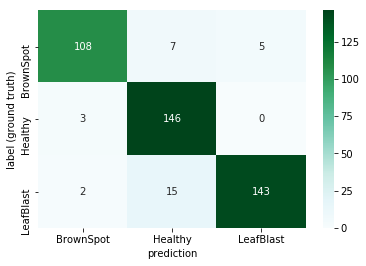


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 99	TRAIN	Loss: 0.13	Correct: 3470/3849(90.15%)
		VALID.:	Loss: 0.16	Correct: 391/429(91.14%)


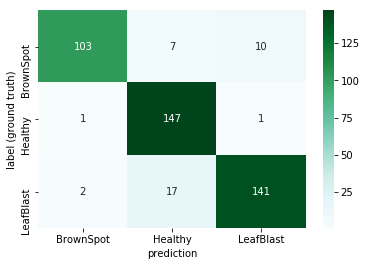


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 100	TRAIN	Loss: 0.55	Correct: 3514/3849(91.3%)
		VALID.:	Loss: 0.17	Correct: 392/429(91.38%)


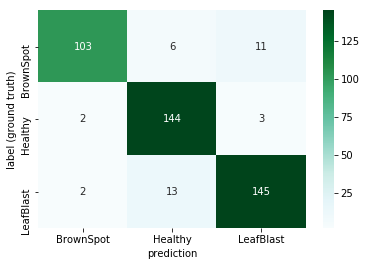


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 101	TRAIN	Loss: 0.15	Correct: 3490/3849(90.67%)
		VALID.:	Loss: 0.25	Correct: 394/429(91.84%)


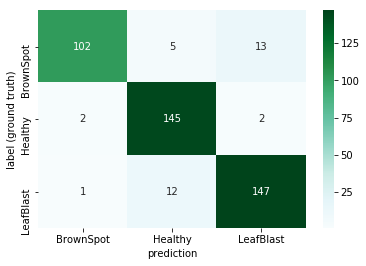


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 102	TRAIN	Loss: 0.24	Correct: 3505/3849(91.06%)
		VALID.:	Loss: 0.18	Correct: 400/429(93.24%)


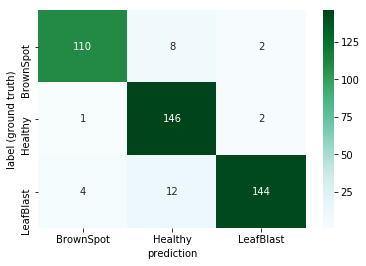


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 103	TRAIN	Loss: 0.4	Correct: 3487/3849(90.59%)
		VALID.:	Loss: 0.16	Correct: 391/429(91.14%)


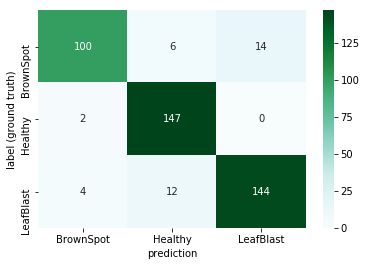


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 104	TRAIN	Loss: 0.06	Correct: 3472/3849(90.21%)
		VALID.:	Loss: 0.14	Correct: 397/429(92.54%)


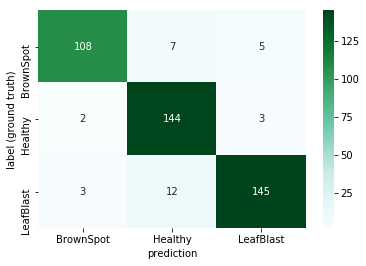


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 105	TRAIN	Loss: 0.09	Correct: 3499/3849(90.91%)
		VALID.:	Loss: 0.14	Correct: 401/429(93.47%)


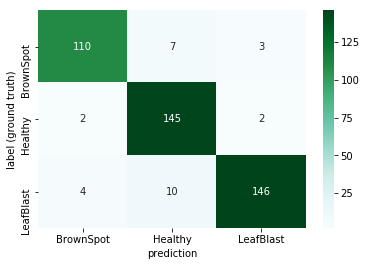


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 106	TRAIN	Loss: 0.67	Correct: 3504/3849(91.04%)
		VALID.:	Loss: 0.06	Correct: 392/429(91.38%)


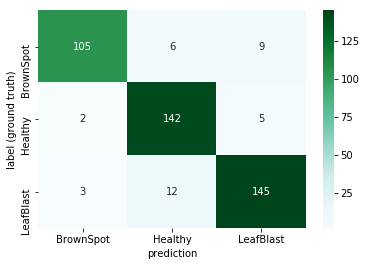


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 107	TRAIN	Loss: 0.5	Correct: 3468/3849(90.1%)
		VALID.:	Loss: 0.1	Correct: 404/429(94.17%)


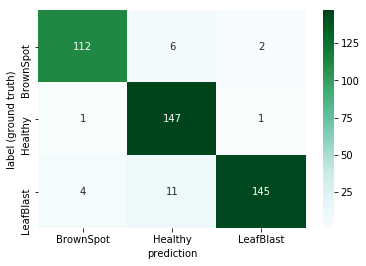

	Best validation accuracy: 94.17

----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 108	TRAIN	Loss: 0.12	Correct: 3510/3849(91.19%)
		VALID.:	Loss: 0.4	Correct: 397/429(92.54%)


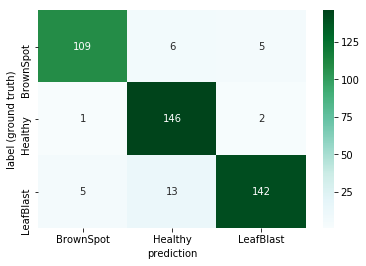


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 109	TRAIN	Loss: 0.2	Correct: 3468/3849(90.1%)
		VALID.:	Loss: 0.06	Correct: 395/429(92.07%)


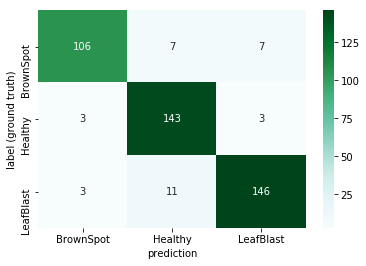


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 110	TRAIN	Loss: 0.33	Correct: 3484/3849(90.52%)
		VALID.:	Loss: 0.53	Correct: 401/429(93.47%)


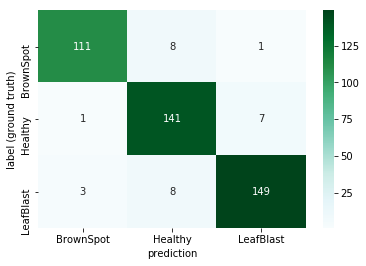


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 111	TRAIN	Loss: 0.32	Correct: 3500/3849(90.93%)
		VALID.:	Loss: 0.15	Correct: 393/429(91.61%)


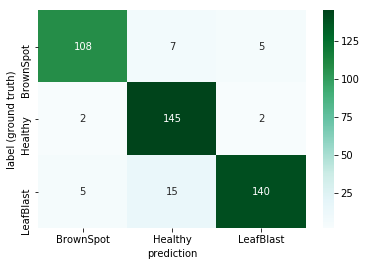


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 112	TRAIN	Loss: 0.11	Correct: 3500/3849(90.93%)
		VALID.:	Loss: 0.11	Correct: 403/429(93.94%)


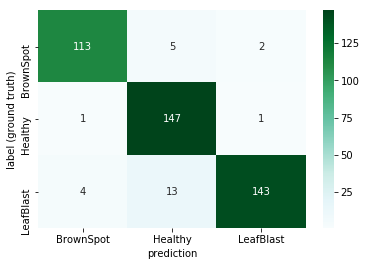


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 113	TRAIN	Loss: 0.58	Correct: 3492/3849(90.72%)
		VALID.:	Loss: 0.28	Correct: 396/429(92.31%)


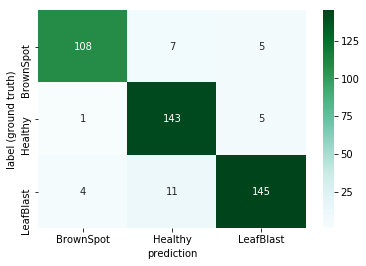


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 114	TRAIN	Loss: 0.57	Correct: 3492/3849(90.72%)
		VALID.:	Loss: 0.15	Correct: 395/429(92.07%)


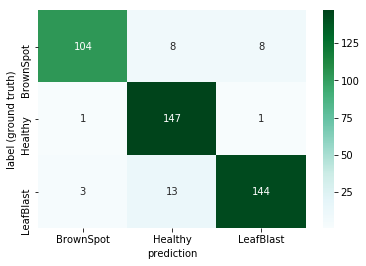


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 115	TRAIN	Loss: 0.35	Correct: 3475/3849(90.28%)
		VALID.:	Loss: 0.14	Correct: 398/429(92.77%)


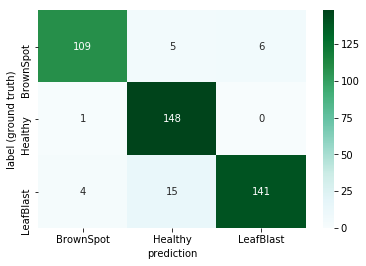


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 116	TRAIN	Loss: 0.29	Correct: 3506/3849(91.09%)
		VALID.:	Loss: 0.33	Correct: 384/429(89.51%)


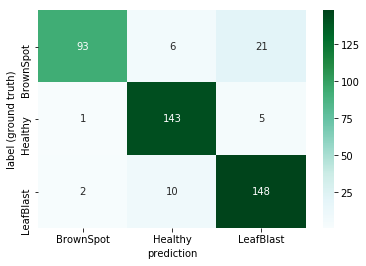


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 117	TRAIN	Loss: 0.6	Correct: 3470/3849(90.15%)
		VALID.:	Loss: 0.4	Correct: 396/429(92.31%)


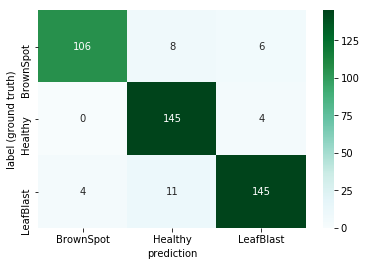


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 118	TRAIN	Loss: 0.09	Correct: 3508/3849(91.14%)
		VALID.:	Loss: 0.24	Correct: 398/429(92.77%)


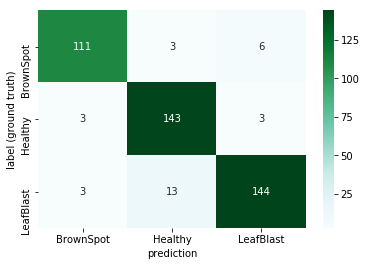


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 119	TRAIN	Loss: 0.14	Correct: 3470/3849(90.15%)
		VALID.:	Loss: 0.29	Correct: 397/429(92.54%)


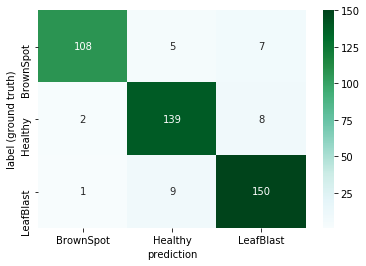


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 120	TRAIN	Loss: 0.15	Correct: 3485/3849(90.54%)
		VALID.:	Loss: 0.22	Correct: 388/429(90.44%)


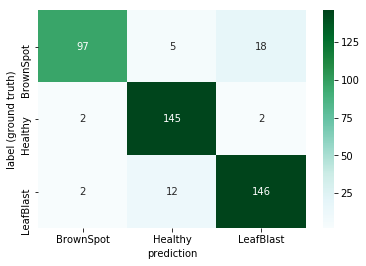


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 121	TRAIN	Loss: 0.22	Correct: 3525/3849(91.58%)
		VALID.:	Loss: 0.28	Correct: 403/429(93.94%)


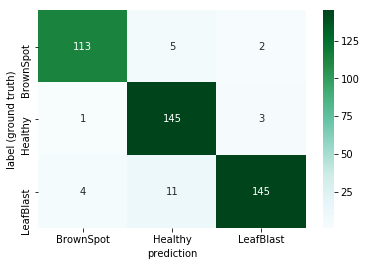


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 122	TRAIN	Loss: 0.34	Correct: 3503/3849(91.01%)
		VALID.:	Loss: 0.66	Correct: 398/429(92.77%)


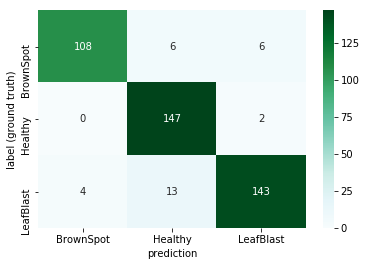


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 123	TRAIN	Loss: 0.48	Correct: 3505/3849(91.06%)
		VALID.:	Loss: 0.15	Correct: 397/429(92.54%)


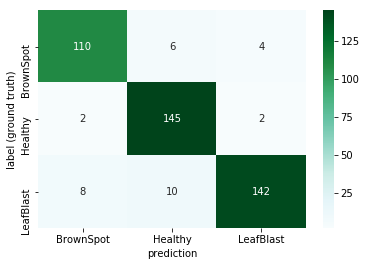


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 124	TRAIN	Loss: 0.15	Correct: 3491/3849(90.7%)
		VALID.:	Loss: 0.25	Correct: 403/429(93.94%)


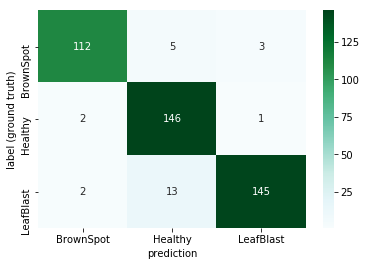


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 125	TRAIN	Loss: 0.12	Correct: 3520/3849(91.45%)
		VALID.:	Loss: 0.1	Correct: 402/429(93.71%)


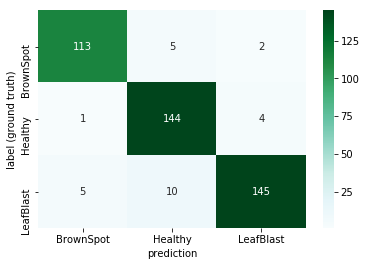


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 126	TRAIN	Loss: 0.05	Correct: 3510/3849(91.19%)
		VALID.:	Loss: 0.47	Correct: 397/429(92.54%)


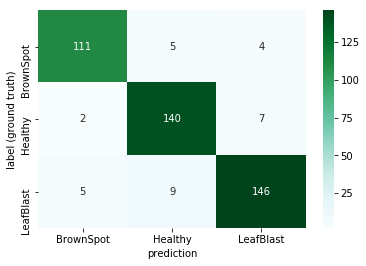


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 127	TRAIN	Loss: 1.23	Correct: 3506/3849(91.09%)
		VALID.:	Loss: 0.13	Correct: 391/429(91.14%)


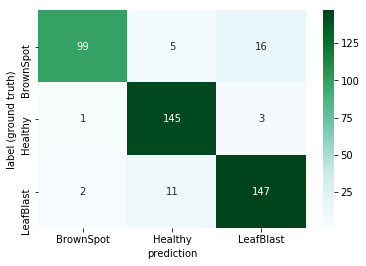


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 128	TRAIN	Loss: 0.08	Correct: 3496/3849(90.83%)
		VALID.:	Loss: 0.37	Correct: 386/429(89.98%)


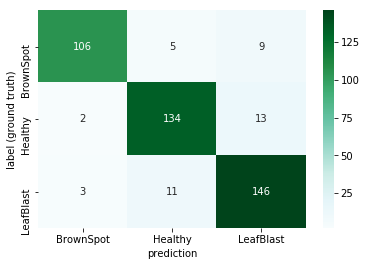


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 129	TRAIN	Loss: 0.03	Correct: 3495/3849(90.8%)
		VALID.:	Loss: 0.4	Correct: 400/429(93.24%)


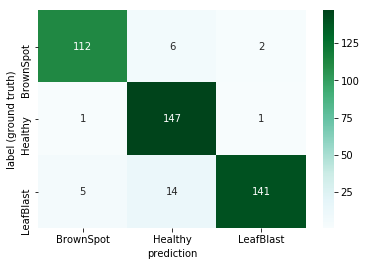


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 130	TRAIN	Loss: 0.38	Correct: 3533/3849(91.79%)
		VALID.:	Loss: 0.05	Correct: 403/429(93.94%)


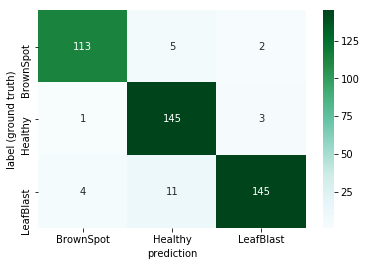


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 131	TRAIN	Loss: 0.36	Correct: 3514/3849(91.3%)
		VALID.:	Loss: 0.39	Correct: 401/429(93.47%)


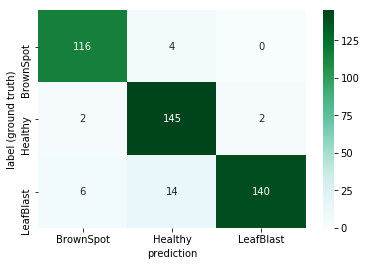


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 132	TRAIN	Loss: 0.15	Correct: 3522/3849(91.5%)
		VALID.:	Loss: 0.07	Correct: 400/429(93.24%)


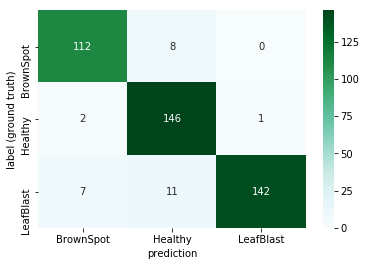


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 133	TRAIN	Loss: 0.15	Correct: 3526/3849(91.61%)
		VALID.:	Loss: 0.4	Correct: 399/429(93.01%)


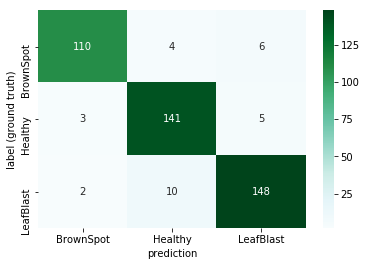


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 134	TRAIN	Loss: 0.02	Correct: 3512/3849(91.24%)
		VALID.:	Loss: 0.15	Correct: 405/429(94.41%)


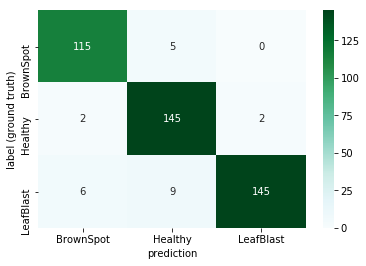

	Best validation accuracy: 94.41

----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 135	TRAIN	Loss: 0.38	Correct: 3494/3849(90.78%)
		VALID.:	Loss: 0.07	Correct: 399/429(93.01%)


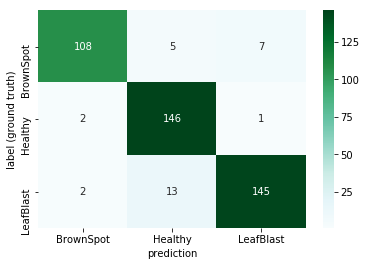


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 136	TRAIN	Loss: 0.32	Correct: 3518/3849(91.4%)
		VALID.:	Loss: 0.45	Correct: 401/429(93.47%)


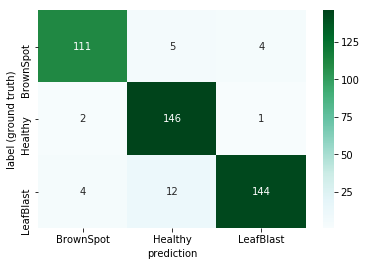


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 137	TRAIN	Loss: 0.16	Correct: 3519/3849(91.43%)
		VALID.:	Loss: 0.26	Correct: 389/429(90.68%)


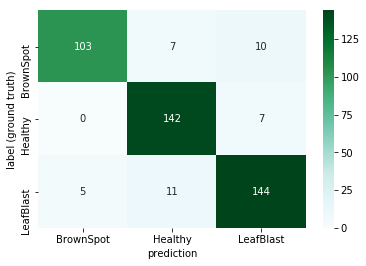


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 138	TRAIN	Loss: 0.41	Correct: 3495/3849(90.8%)
		VALID.:	Loss: 0.13	Correct: 394/429(91.84%)


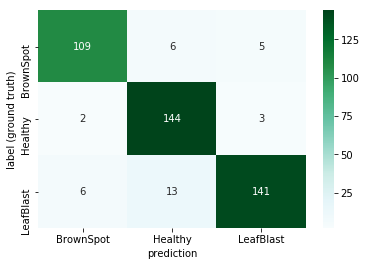


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 139	TRAIN	Loss: 0.06	Correct: 3503/3849(91.01%)
		VALID.:	Loss: 0.03	Correct: 397/429(92.54%)


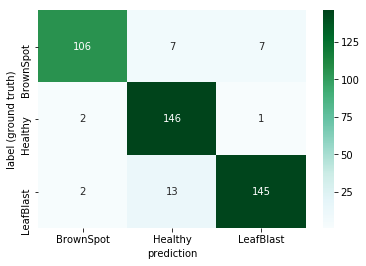


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 140	TRAIN	Loss: 0.35	Correct: 3535/3849(91.84%)
		VALID.:	Loss: 0.18	Correct: 397/429(92.54%)


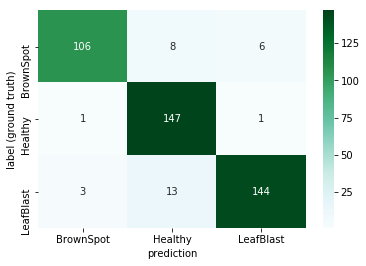


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 141	TRAIN	Loss: 0.19	Correct: 3517/3849(91.37%)
		VALID.:	Loss: 0.35	Correct: 406/429(94.64%)


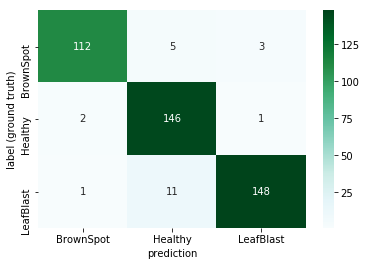

	Best validation accuracy: 94.64

----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 142	TRAIN	Loss: 0.16	Correct: 3526/3849(91.61%)
		VALID.:	Loss: 0.09	Correct: 405/429(94.41%)


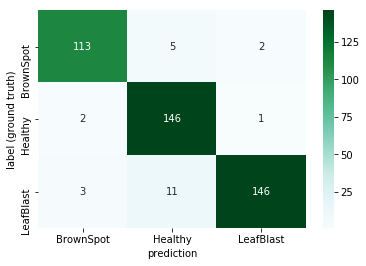


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 143	TRAIN	Loss: 0.17	Correct: 3503/3849(91.01%)
		VALID.:	Loss: 0.18	Correct: 397/429(92.54%)


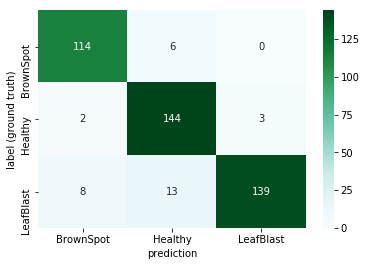


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 144	TRAIN	Loss: 0.23	Correct: 3528/3849(91.66%)
		VALID.:	Loss: 0.06	Correct: 396/429(92.31%)


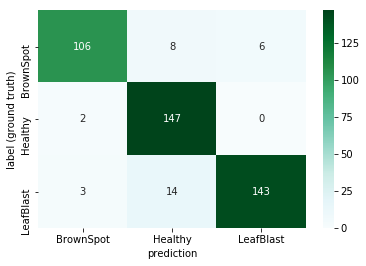


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 145	TRAIN	Loss: 0.43	Correct: 3514/3849(91.3%)
		VALID.:	Loss: 0.09	Correct: 404/429(94.17%)


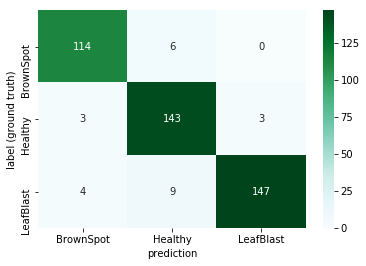


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 146	TRAIN	Loss: 0.15	Correct: 3519/3849(91.43%)
		VALID.:	Loss: 0.19	Correct: 401/429(93.47%)


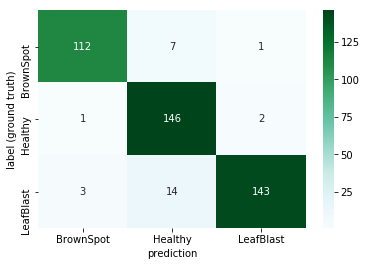


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 147	TRAIN	Loss: 0.03	Correct: 3543/3849(92.05%)
		VALID.:	Loss: 0.24	Correct: 402/429(93.71%)


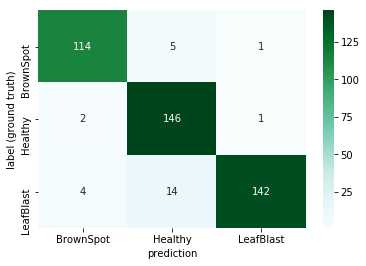


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 148	TRAIN	Loss: 0.25	Correct: 3551/3849(92.26%)
		VALID.:	Loss: 0.28	Correct: 400/429(93.24%)


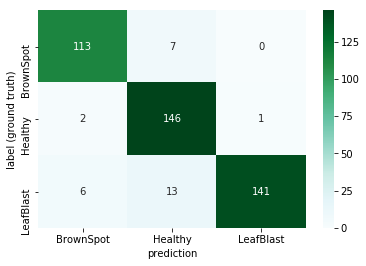


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 149	TRAIN	Loss: 0.02	Correct: 3526/3849(91.61%)
		VALID.:	Loss: 0.15	Correct: 397/429(92.54%)


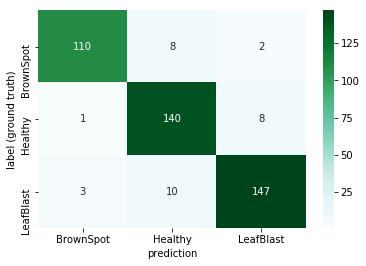


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 150	TRAIN	Loss: 0.18	Correct: 3495/3849(90.8%)
		VALID.:	Loss: 0.41	Correct: 398/429(92.77%)


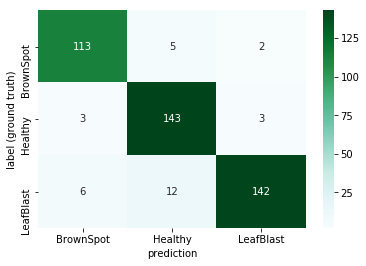


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 151	TRAIN	Loss: 0.14	Correct: 3526/3849(91.61%)
		VALID.:	Loss: 0.41	Correct: 397/429(92.54%)


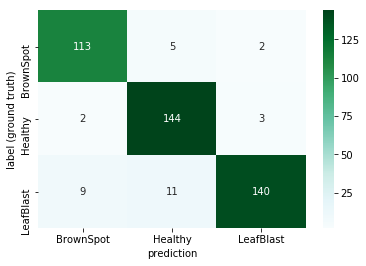


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 152	TRAIN	Loss: 0.01	Correct: 3541/3849(92.0%)
		VALID.:	Loss: 0.28	Correct: 400/429(93.24%)


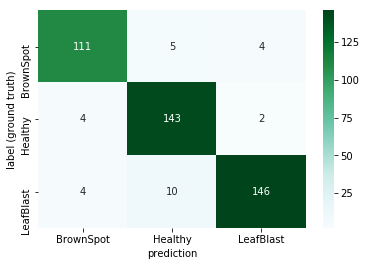


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 153	TRAIN	Loss: 0.04	Correct: 3520/3849(91.45%)
		VALID.:	Loss: 0.51	Correct: 406/429(94.64%)


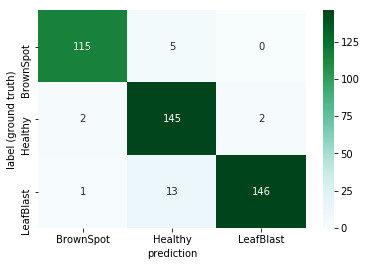


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 154	TRAIN	Loss: 0.21	Correct: 3525/3849(91.58%)
		VALID.:	Loss: 0.24	Correct: 403/429(93.94%)


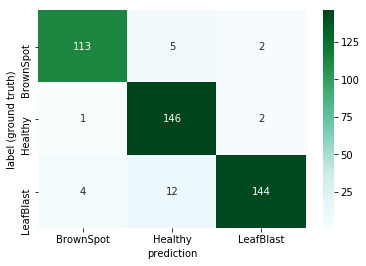


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 155	TRAIN	Loss: 0.06	Correct: 3569/3849(92.73%)
		VALID.:	Loss: 0.13	Correct: 396/429(92.31%)


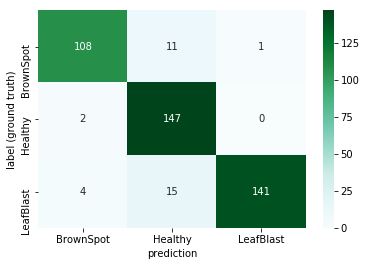


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 156	TRAIN	Loss: 0.32	Correct: 3540/3849(91.97%)
		VALID.:	Loss: 0.18	Correct: 405/429(94.41%)


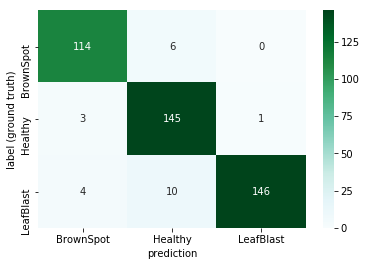


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 157	TRAIN	Loss: 0.22	Correct: 3533/3849(91.79%)
		VALID.:	Loss: 0.3	Correct: 395/429(92.07%)


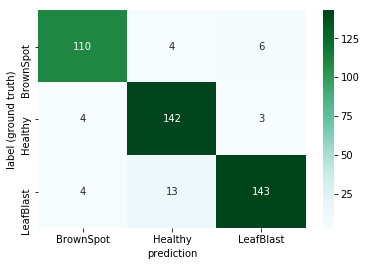


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 158	TRAIN	Loss: 0.09	Correct: 3539/3849(91.95%)
		VALID.:	Loss: 0.1	Correct: 396/429(92.31%)


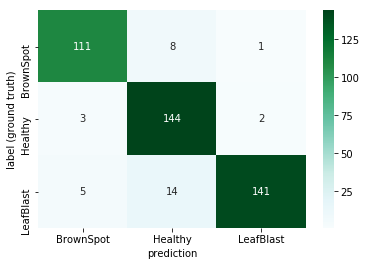


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 159	TRAIN	Loss: 0.35	Correct: 3536/3849(91.87%)
		VALID.:	Loss: 0.04	Correct: 396/429(92.31%)


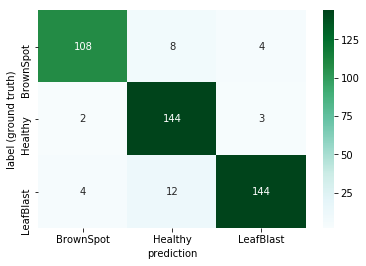


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 160	TRAIN	Loss: 0.08	Correct: 3534/3849(91.82%)
		VALID.:	Loss: 0.46	Correct: 403/429(93.94%)


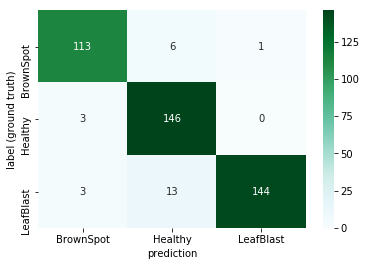


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 161	TRAIN	Loss: 0.07	Correct: 3543/3849(92.05%)
		VALID.:	Loss: 0.05	Correct: 404/429(94.17%)


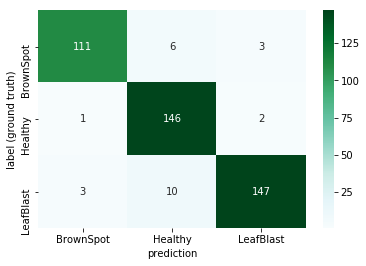


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 162	TRAIN	Loss: 0.01	Correct: 3558/3849(92.44%)
		VALID.:	Loss: 0.04	Correct: 396/429(92.31%)


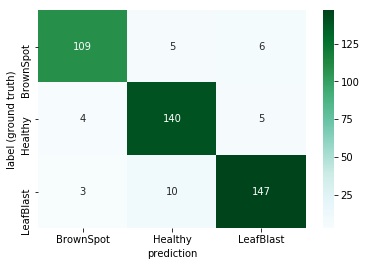


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 163	TRAIN	Loss: 0.17	Correct: 3537/3849(91.89%)
		VALID.:	Loss: 0.15	Correct: 402/429(93.71%)


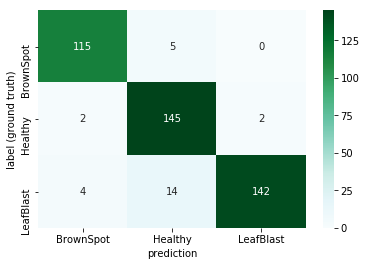


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 164	TRAIN	Loss: 0.17	Correct: 3540/3849(91.97%)
		VALID.:	Loss: 0.49	Correct: 403/429(93.94%)


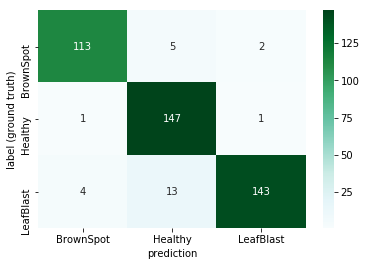


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 165	TRAIN	Loss: 0.1	Correct: 3534/3849(91.82%)
		VALID.:	Loss: 0.21	Correct: 390/429(90.91%)


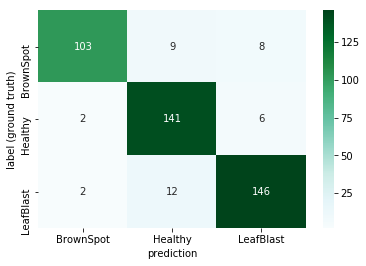


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 166	TRAIN	Loss: 0.22	Correct: 3552/3849(92.28%)
		VALID.:	Loss: 0.22	Correct: 404/429(94.17%)


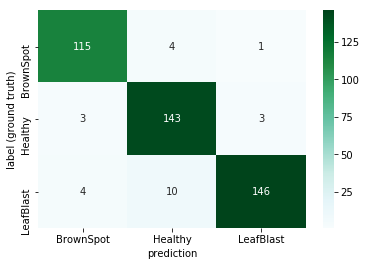


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 167	TRAIN	Loss: 0.16	Correct: 3513/3849(91.27%)
		VALID.:	Loss: 0.18	Correct: 396/429(92.31%)


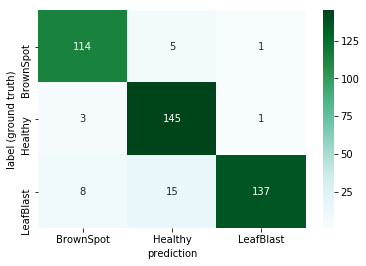


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 168	TRAIN	Loss: 0.52	Correct: 3554/3849(92.34%)
		VALID.:	Loss: 0.39	Correct: 402/429(93.71%)


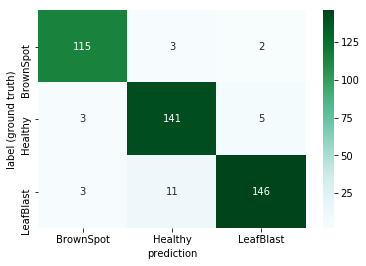


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 169	TRAIN	Loss: 0.19	Correct: 3515/3849(91.32%)
		VALID.:	Loss: 0.06	Correct: 395/429(92.07%)


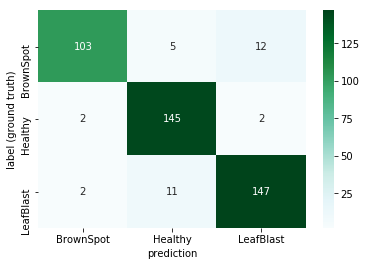


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 170	TRAIN	Loss: 0.25	Correct: 3541/3849(92.0%)
		VALID.:	Loss: 0.21	Correct: 399/429(93.01%)


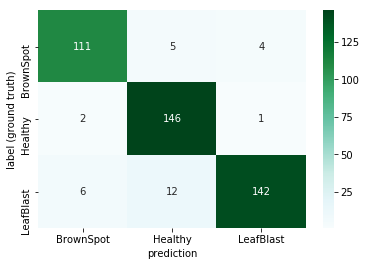


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 171	TRAIN	Loss: 0.35	Correct: 3540/3849(91.97%)
		VALID.:	Loss: 0.25	Correct: 396/429(92.31%)


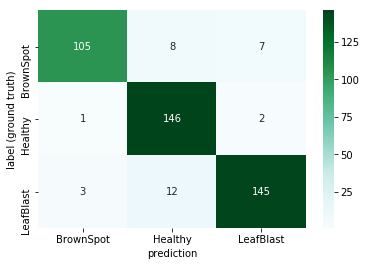


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 172	TRAIN	Loss: 0.07	Correct: 3559/3849(92.47%)
		VALID.:	Loss: 0.15	Correct: 398/429(92.77%)


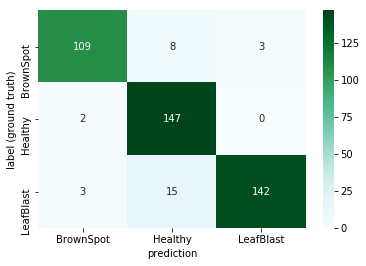


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 173	TRAIN	Loss: 0.22	Correct: 3537/3849(91.89%)
		VALID.:	Loss: 0.23	Correct: 395/429(92.07%)


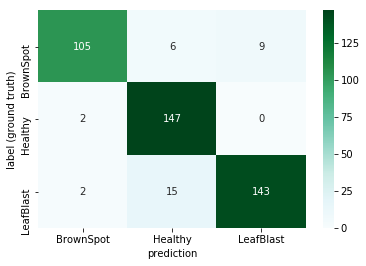


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 174	TRAIN	Loss: 0.21	Correct: 3531/3849(91.74%)
		VALID.:	Loss: 0.24	Correct: 402/429(93.71%)


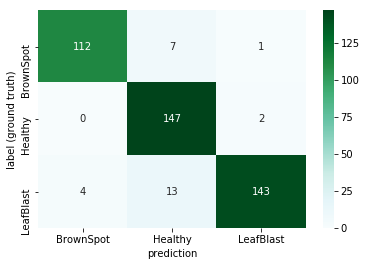


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 175	TRAIN	Loss: 0.2	Correct: 3566/3849(92.65%)
		VALID.:	Loss: 0.15	Correct: 404/429(94.17%)


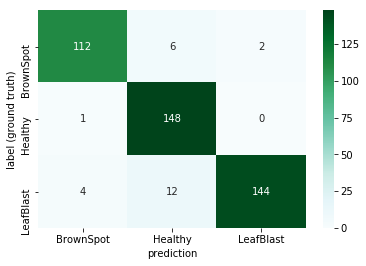


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 176	TRAIN	Loss: 0.18	Correct: 3526/3849(91.61%)
		VALID.:	Loss: 0.27	Correct: 401/429(93.47%)


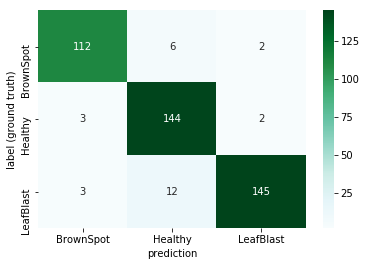


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 177	TRAIN	Loss: 0.39	Correct: 3549/3849(92.21%)
		VALID.:	Loss: 0.21	Correct: 401/429(93.47%)


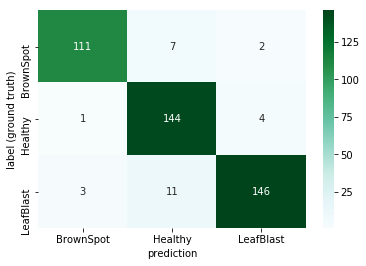


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 178	TRAIN	Loss: 0.39	Correct: 3568/3849(92.7%)
		VALID.:	Loss: 0.28	Correct: 403/429(93.94%)


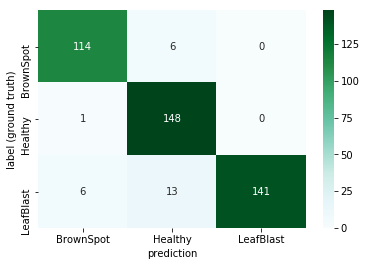


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 179	TRAIN	Loss: 0.09	Correct: 3538/3849(91.92%)
		VALID.:	Loss: 0.34	Correct: 400/429(93.24%)


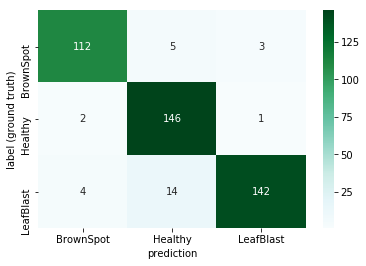


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 180	TRAIN	Loss: 0.22	Correct: 3568/3849(92.7%)
		VALID.:	Loss: 0.04	Correct: 394/429(91.84%)


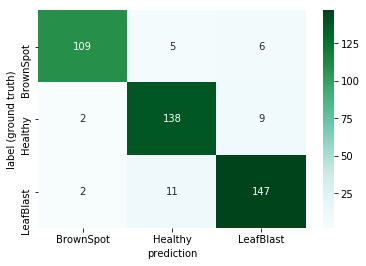


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 181	TRAIN	Loss: 0.43	Correct: 3547/3849(92.15%)
		VALID.:	Loss: 0.52	Correct: 401/429(93.47%)


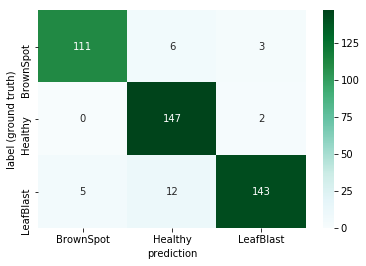


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 182	TRAIN	Loss: 0.28	Correct: 3548/3849(92.18%)
		VALID.:	Loss: 0.27	Correct: 401/429(93.47%)


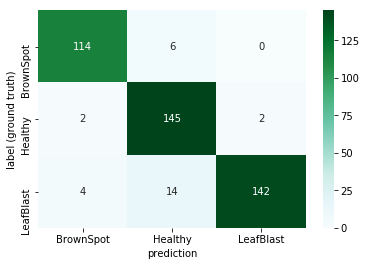


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 183	TRAIN	Loss: 0.32	Correct: 3521/3849(91.48%)
		VALID.:	Loss: 0.31	Correct: 397/429(92.54%)


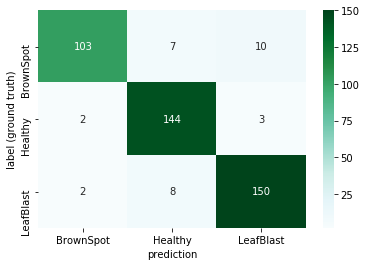


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 184	TRAIN	Loss: 0.56	Correct: 3549/3849(92.21%)
		VALID.:	Loss: 0.12	Correct: 403/429(93.94%)


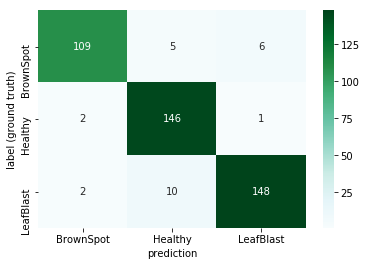


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 185	TRAIN	Loss: 0.23	Correct: 3540/3849(91.97%)
		VALID.:	Loss: 0.03	Correct: 406/429(94.64%)


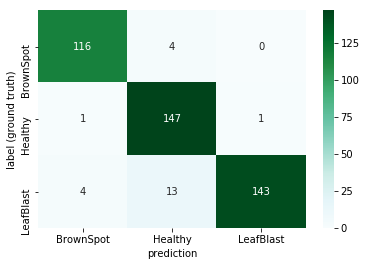


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 186	TRAIN	Loss: 0.05	Correct: 3524/3849(91.56%)
		VALID.:	Loss: 0.09	Correct: 399/429(93.01%)


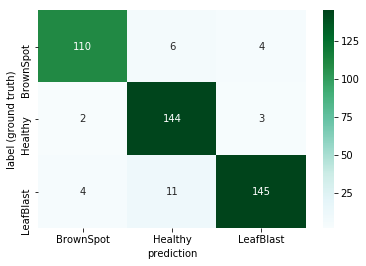


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 187	TRAIN	Loss: 0.02	Correct: 3548/3849(92.18%)
		VALID.:	Loss: 0.31	Correct: 399/429(93.01%)


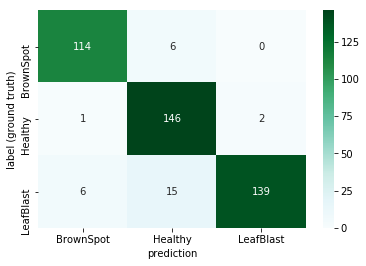


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 188	TRAIN	Loss: 0.22	Correct: 3530/3849(91.71%)
		VALID.:	Loss: 0.16	Correct: 398/429(92.77%)


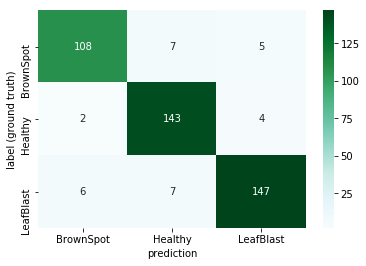


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 189	TRAIN	Loss: 0.55	Correct: 3541/3849(92.0%)
		VALID.:	Loss: 0.39	Correct: 403/429(93.94%)


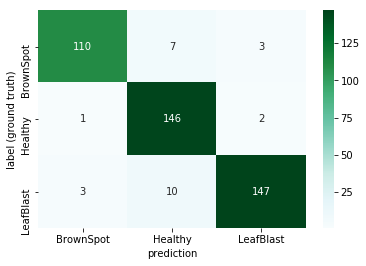


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 190	TRAIN	Loss: 0.05	Correct: 3549/3849(92.21%)
		VALID.:	Loss: 0.17	Correct: 405/429(94.41%)


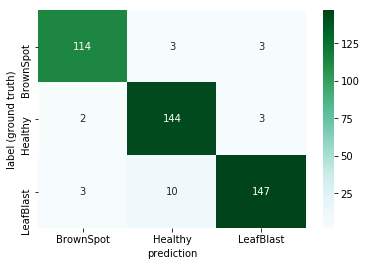


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 191	TRAIN	Loss: 0.2	Correct: 3574/3849(92.86%)
		VALID.:	Loss: 0.05	Correct: 403/429(93.94%)


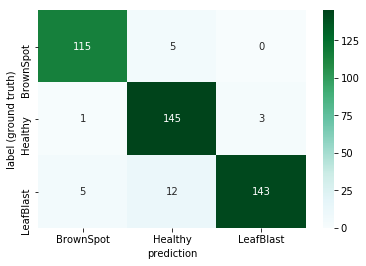


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 192	TRAIN	Loss: 0.41	Correct: 3528/3849(91.66%)
		VALID.:	Loss: 0.24	Correct: 397/429(92.54%)


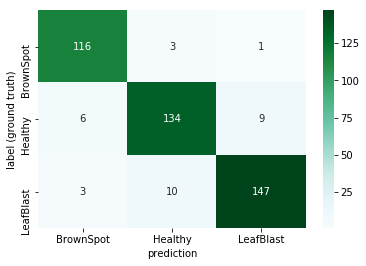


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 193	TRAIN	Loss: 0.04	Correct: 3542/3849(92.02%)
		VALID.:	Loss: 0.06	Correct: 402/429(93.71%)


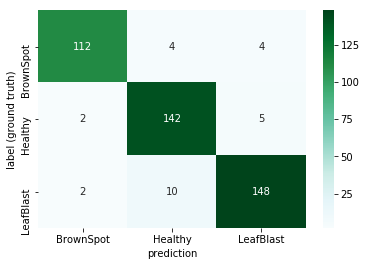


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 194	TRAIN	Loss: 0.2	Correct: 3561/3849(92.52%)
		VALID.:	Loss: 0.06	Correct: 393/429(91.61%)


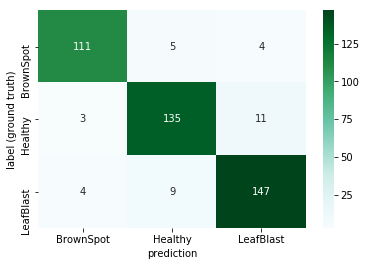


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 195	TRAIN	Loss: 0.74	Correct: 3528/3849(91.66%)
		VALID.:	Loss: 0.04	Correct: 404/429(94.17%)


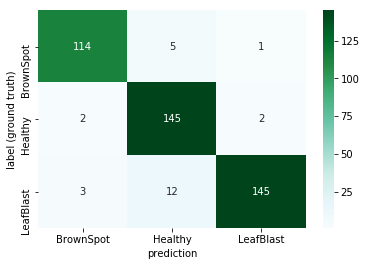


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 196	TRAIN	Loss: 0.05	Correct: 3569/3849(92.73%)
		VALID.:	Loss: 0.26	Correct: 403/429(93.94%)


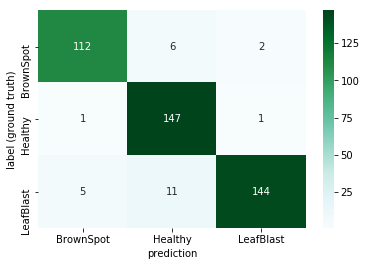


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 197	TRAIN	Loss: 0.74	Correct: 3542/3849(92.02%)
		VALID.:	Loss: 0.13	Correct: 393/429(91.61%)


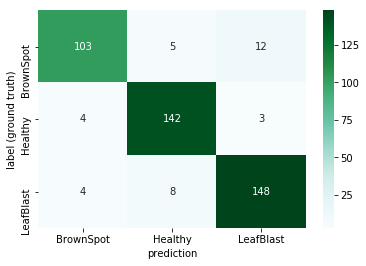


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 198	TRAIN	Loss: 0.16	Correct: 3523/3849(91.53%)
		VALID.:	Loss: 0.29	Correct: 393/429(91.61%)


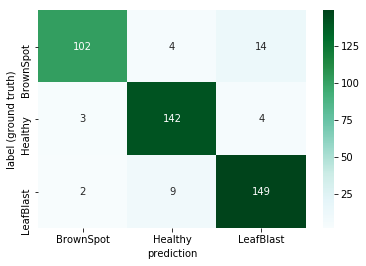


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 199	TRAIN	Loss: 0.18	Correct: 3557/3849(92.41%)
		VALID.:	Loss: 0.41	Correct: 393/429(91.61%)


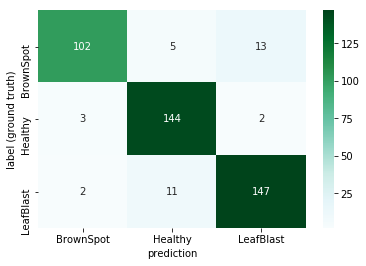


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 200	TRAIN	Loss: 0.12	Correct: 3578/3849(92.96%)
		VALID.:	Loss: 0.09	Correct: 399/429(93.01%)


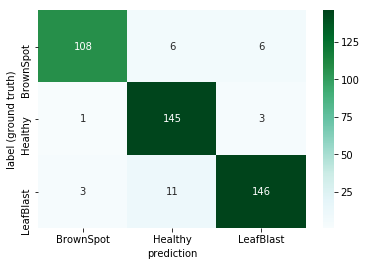


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 201	TRAIN	Loss: 0.01	Correct: 3571/3849(92.78%)
		VALID.:	Loss: 0.2	Correct: 400/429(93.24%)


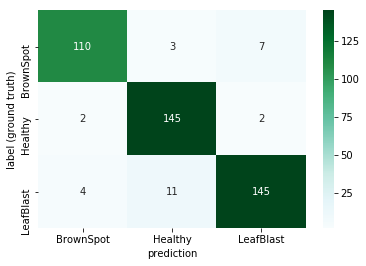


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 202	TRAIN	Loss: 0.44	Correct: 3587/3849(93.19%)
		VALID.:	Loss: 0.33	Correct: 397/429(92.54%)


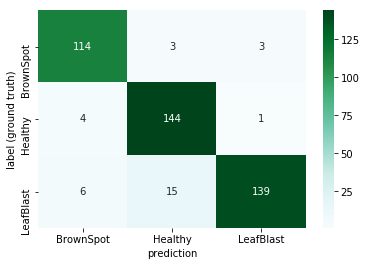


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 203	TRAIN	Loss: 0.64	Correct: 3558/3849(92.44%)
		VALID.:	Loss: 0.11	Correct: 395/429(92.07%)


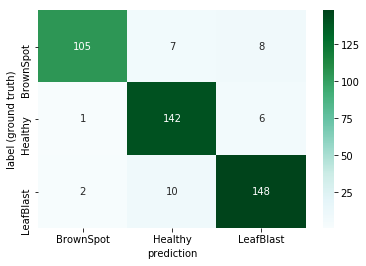


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 204	TRAIN	Loss: 0.12	Correct: 3559/3849(92.47%)
		VALID.:	Loss: 0.68	Correct: 394/429(91.84%)


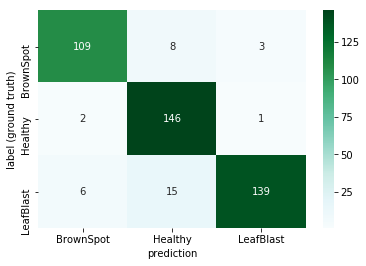


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 205	TRAIN	Loss: 0.38	Correct: 3566/3849(92.65%)
		VALID.:	Loss: 0.19	Correct: 405/429(94.41%)


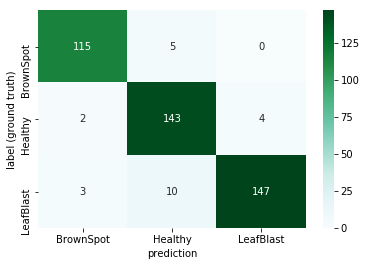


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 206	TRAIN	Loss: 0.14	Correct: 3587/3849(93.19%)
		VALID.:	Loss: 0.04	Correct: 398/429(92.77%)


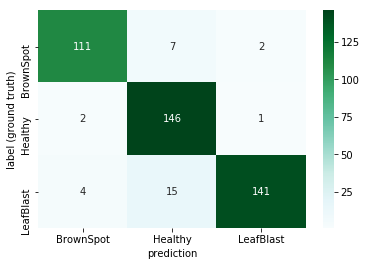


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 207	TRAIN	Loss: 0.02	Correct: 3574/3849(92.86%)
		VALID.:	Loss: 0.22	Correct: 401/429(93.47%)


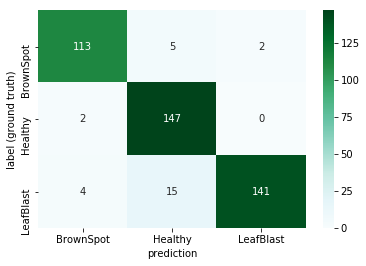


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 208	TRAIN	Loss: 0.11	Correct: 3572/3849(92.8%)
		VALID.:	Loss: 0.21	Correct: 403/429(93.94%)


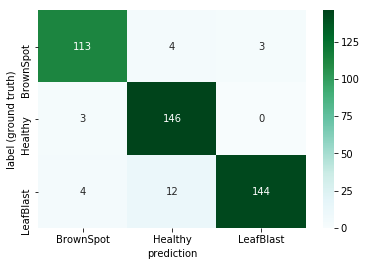


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 209	TRAIN	Loss: 0.05	Correct: 3549/3849(92.21%)
		VALID.:	Loss: 0.29	Correct: 401/429(93.47%)


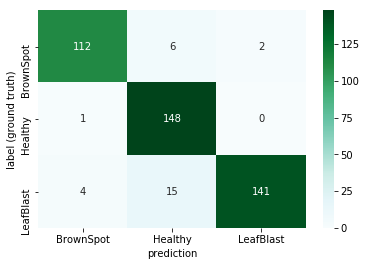


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 210	TRAIN	Loss: 0.23	Correct: 3561/3849(92.52%)
		VALID.:	Loss: 0.16	Correct: 401/429(93.47%)


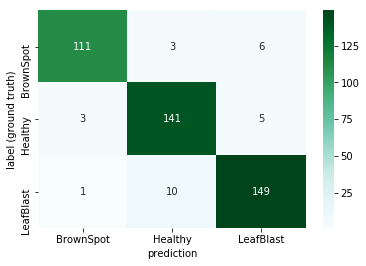


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 211	TRAIN	Loss: 0.01	Correct: 3571/3849(92.78%)
		VALID.:	Loss: 0.16	Correct: 401/429(93.47%)


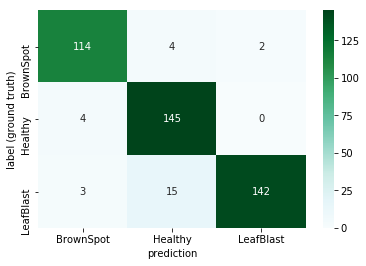


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 212	TRAIN	Loss: 0.07	Correct: 3569/3849(92.73%)
		VALID.:	Loss: 0.46	Correct: 400/429(93.24%)


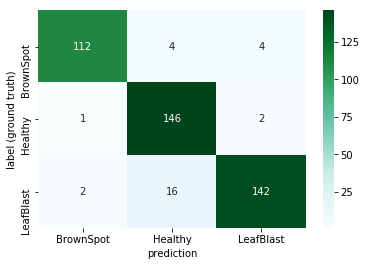


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 213	TRAIN	Loss: 0.01	Correct: 3587/3849(93.19%)
		VALID.:	Loss: 0.06	Correct: 407/429(94.87%)


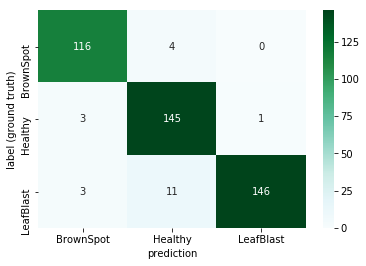

	Best validation accuracy: 94.87

----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 214	TRAIN	Loss: 0.37	Correct: 3544/3849(92.08%)
		VALID.:	Loss: 0.03	Correct: 401/429(93.47%)


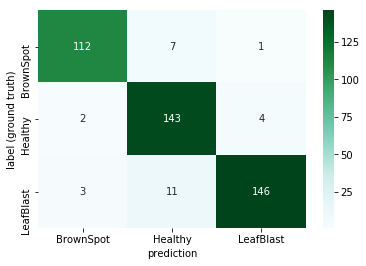


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 215	TRAIN	Loss: 0.09	Correct: 3559/3849(92.47%)
		VALID.:	Loss: 0.09	Correct: 396/429(92.31%)


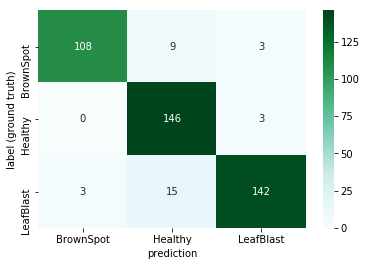


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 216	TRAIN	Loss: 0.04	Correct: 3570/3849(92.75%)
		VALID.:	Loss: 0.03	Correct: 396/429(92.31%)


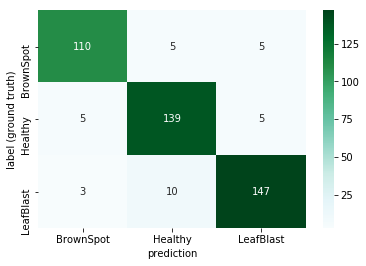


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 217	TRAIN	Loss: 0.12	Correct: 3567/3849(92.67%)
		VALID.:	Loss: 0.33	Correct: 399/429(93.01%)


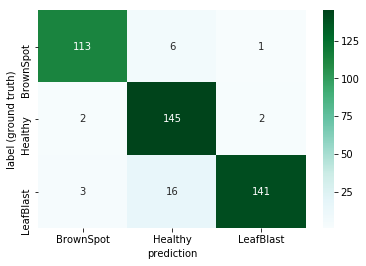


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 218	TRAIN	Loss: 0.48	Correct: 3564/3849(92.6%)
		VALID.:	Loss: 0.07	Correct: 404/429(94.17%)


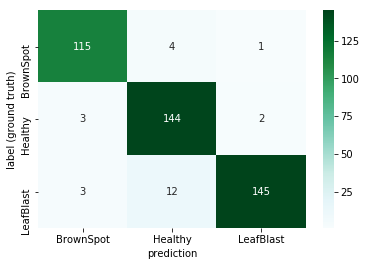


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 219	TRAIN	Loss: 0.19	Correct: 3564/3849(92.6%)
		VALID.:	Loss: 0.33	Correct: 395/429(92.07%)


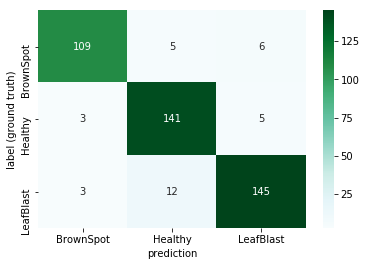


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 220	TRAIN	Loss: 0.03	Correct: 3566/3849(92.65%)
		VALID.:	Loss: 0.13	Correct: 400/429(93.24%)


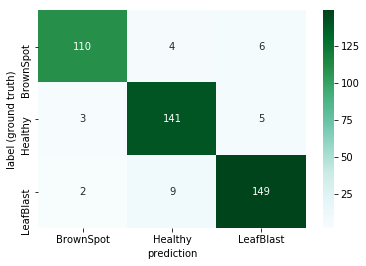


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 221	TRAIN	Loss: 0.37	Correct: 3577/3849(92.93%)
		VALID.:	Loss: 0.22	Correct: 404/429(94.17%)


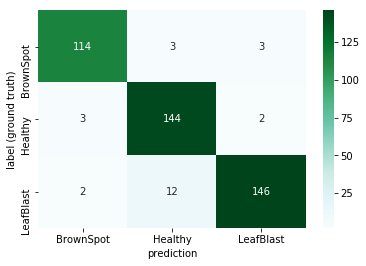


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 222	TRAIN	Loss: 0.15	Correct: 3557/3849(92.41%)
		VALID.:	Loss: 0.04	Correct: 406/429(94.64%)


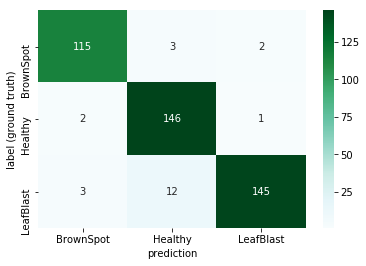


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 223	TRAIN	Loss: 0.97	Correct: 3562/3849(92.54%)
		VALID.:	Loss: 0.32	Correct: 404/429(94.17%)


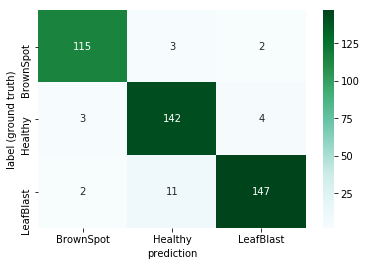


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 224	TRAIN	Loss: 0.04	Correct: 3578/3849(92.96%)
		VALID.:	Loss: 0.08	Correct: 403/429(93.94%)


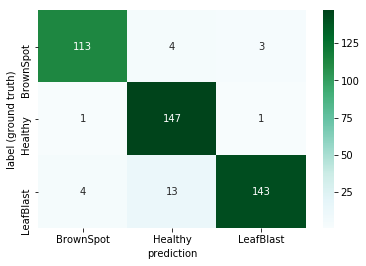


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 225	TRAIN	Loss: 0.68	Correct: 3541/3849(92.0%)
		VALID.:	Loss: 0.11	Correct: 401/429(93.47%)


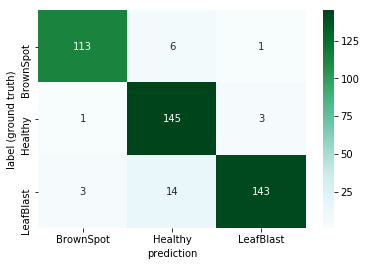


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 226	TRAIN	Loss: 0.55	Correct: 3572/3849(92.8%)
		VALID.:	Loss: 0.45	Correct: 402/429(93.71%)


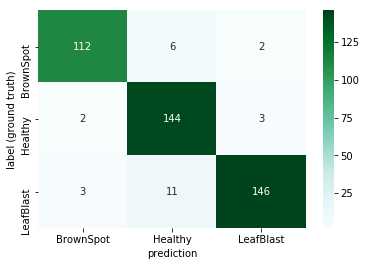


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 227	TRAIN	Loss: 0.06	Correct: 3542/3849(92.02%)
		VALID.:	Loss: 0.01	Correct: 404/429(94.17%)


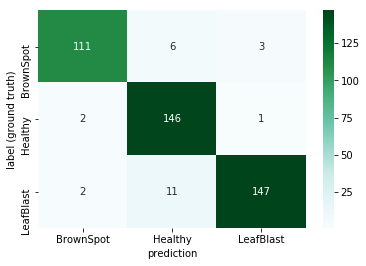


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 228	TRAIN	Loss: 0.21	Correct: 3572/3849(92.8%)
		VALID.:	Loss: 0.21	Correct: 399/429(93.01%)


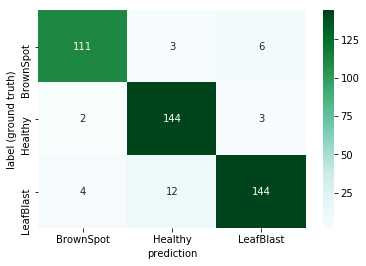


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 229	TRAIN	Loss: 0.18	Correct: 3577/3849(92.93%)
		VALID.:	Loss: 0.21	Correct: 402/429(93.71%)


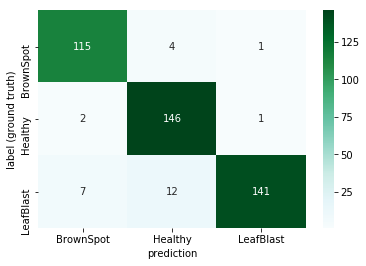


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 230	TRAIN	Loss: 0.61	Correct: 3568/3849(92.7%)
		VALID.:	Loss: 0.32	Correct: 398/429(92.77%)


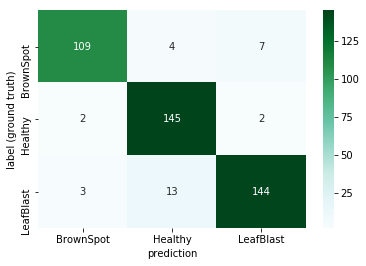


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 231	TRAIN	Loss: 1.36	Correct: 3545/3849(92.1%)
		VALID.:	Loss: 0.09	Correct: 402/429(93.71%)


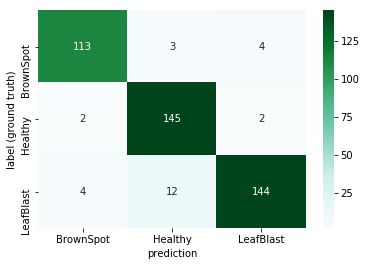


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 232	TRAIN	Loss: 0.23	Correct: 3579/3849(92.99%)
		VALID.:	Loss: 0.17	Correct: 406/429(94.64%)


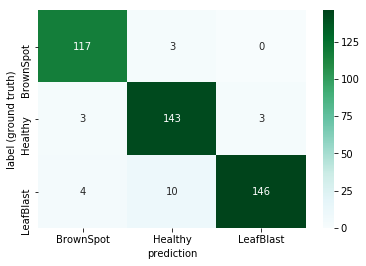


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 233	TRAIN	Loss: 0.03	Correct: 3576/3849(92.91%)
		VALID.:	Loss: 0.09	Correct: 405/429(94.41%)


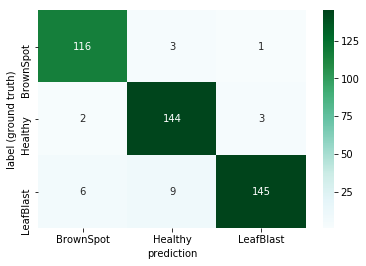


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 234	TRAIN	Loss: 0.03	Correct: 3579/3849(92.99%)
		VALID.:	Loss: 0.05	Correct: 394/429(91.84%)


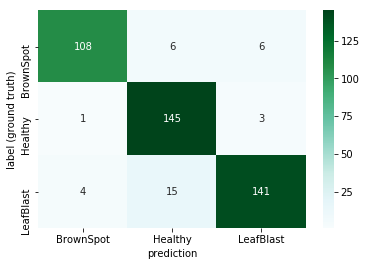


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 235	TRAIN	Loss: 0.02	Correct: 3580/3849(93.01%)
		VALID.:	Loss: 0.23	Correct: 404/429(94.17%)


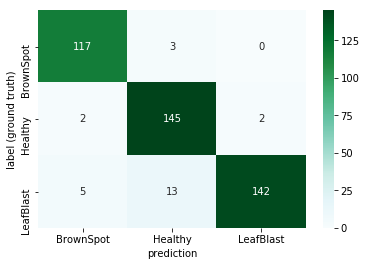


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 236	TRAIN	Loss: 0.16	Correct: 3577/3849(92.93%)
		VALID.:	Loss: 0.08	Correct: 404/429(94.17%)


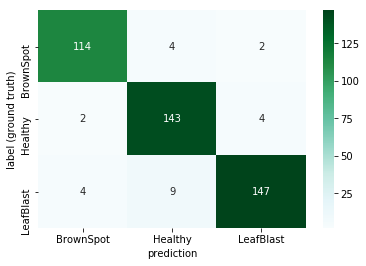


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 237	TRAIN	Loss: 0.7	Correct: 3549/3849(92.21%)
		VALID.:	Loss: 0.33	Correct: 397/429(92.54%)


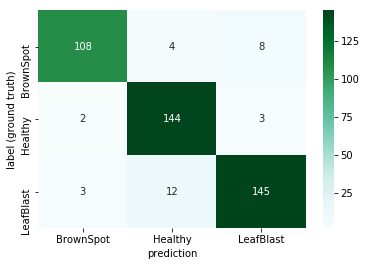


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 238	TRAIN	Loss: 0.46	Correct: 3574/3849(92.86%)
		VALID.:	Loss: 0.19	Correct: 397/429(92.54%)


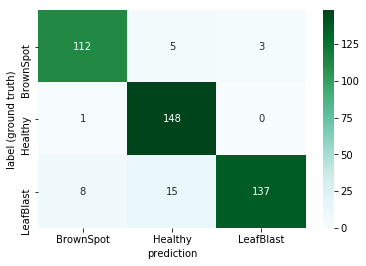


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 239	TRAIN	Loss: 0.19	Correct: 3567/3849(92.67%)
		VALID.:	Loss: 0.27	Correct: 398/429(92.77%)


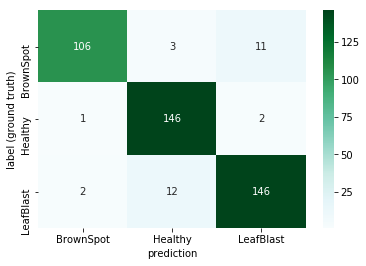


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 240	TRAIN	Loss: 0.09	Correct: 3566/3849(92.65%)
		VALID.:	Loss: 0.06	Correct: 402/429(93.71%)


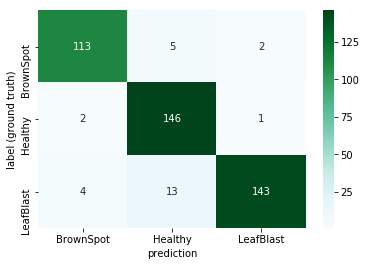


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 241	TRAIN	Loss: 0.52	Correct: 3568/3849(92.7%)
		VALID.:	Loss: 0.12	Correct: 400/429(93.24%)


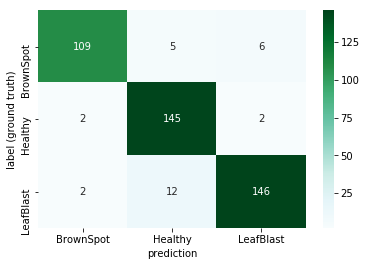


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 242	TRAIN	Loss: 0.53	Correct: 3571/3849(92.78%)
		VALID.:	Loss: 0.58	Correct: 403/429(93.94%)


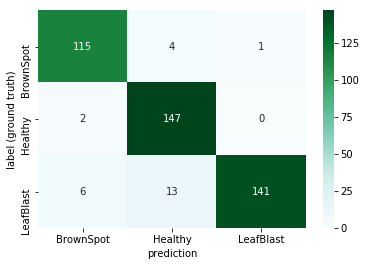


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 243	TRAIN	Loss: 0.1	Correct: 3553/3849(92.31%)
		VALID.:	Loss: 0.26	Correct: 397/429(92.54%)


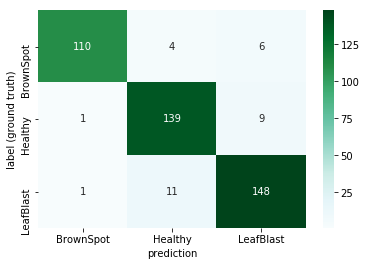


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 244	TRAIN	Loss: 0.24	Correct: 3589/3849(93.24%)
		VALID.:	Loss: 0.19	Correct: 392/429(91.38%)


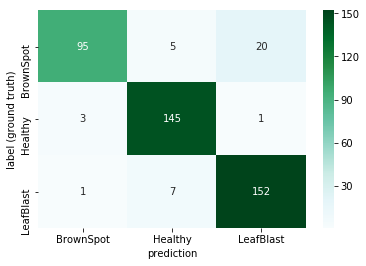


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 245	TRAIN	Loss: 0.19	Correct: 3567/3849(92.67%)
		VALID.:	Loss: 0.31	Correct: 401/429(93.47%)


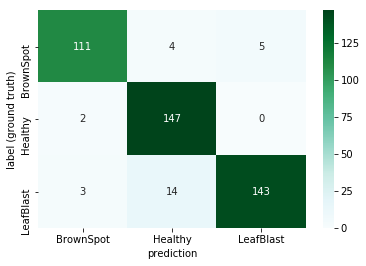


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 246	TRAIN	Loss: 0.34	Correct: 3577/3849(92.93%)
		VALID.:	Loss: 0.51	Correct: 398/429(92.77%)


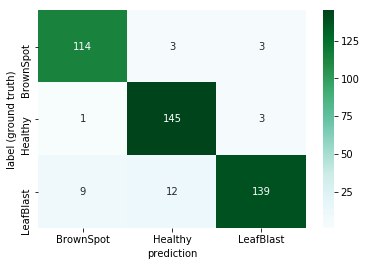


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 247	TRAIN	Loss: 0.04	Correct: 3575/3849(92.88%)
		VALID.:	Loss: 0.03	Correct: 401/429(93.47%)


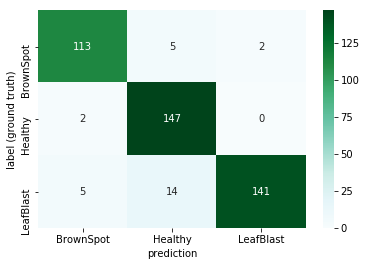


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 248	TRAIN	Loss: 0.21	Correct: 3565/3849(92.62%)
		VALID.:	Loss: 0.54	Correct: 393/429(91.61%)


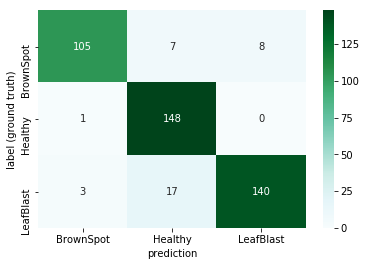


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 249	TRAIN	Loss: 0.09	Correct: 3576/3849(92.91%)
		VALID.:	Loss: 0.08	Correct: 405/429(94.41%)


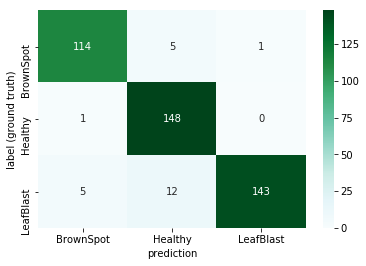


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 250	TRAIN	Loss: 0.07	Correct: 3592/3849(93.32%)
		VALID.:	Loss: 0.12	Correct: 402/429(93.71%)


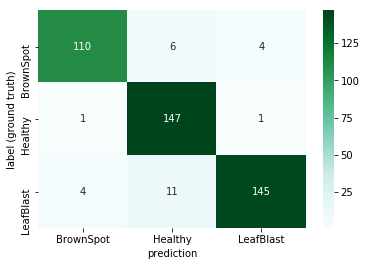


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 251	TRAIN	Loss: 0.4	Correct: 3588/3849(93.22%)
		VALID.:	Loss: 0.36	Correct: 402/429(93.71%)


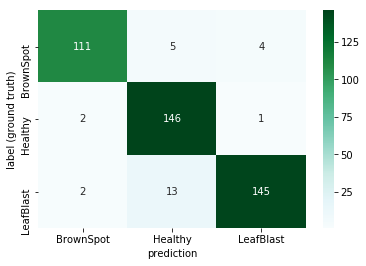


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 252	TRAIN	Loss: 0.01	Correct: 3595/3849(93.4%)
		VALID.:	Loss: 0.28	Correct: 398/429(92.77%)


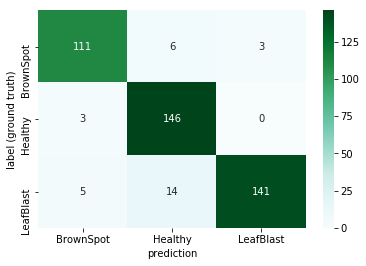


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 253	TRAIN	Loss: 0.53	Correct: 3585/3849(93.14%)
		VALID.:	Loss: 0.24	Correct: 404/429(94.17%)


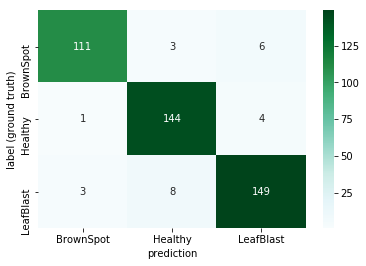


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 254	TRAIN	Loss: 0.4	Correct: 3585/3849(93.14%)
		VALID.:	Loss: 0.53	Correct: 395/429(92.07%)


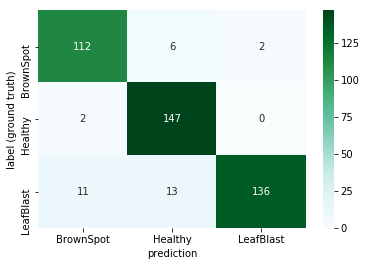


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 255	TRAIN	Loss: 0.15	Correct: 3610/3849(93.79%)
		VALID.:	Loss: 0.27	Correct: 406/429(94.64%)


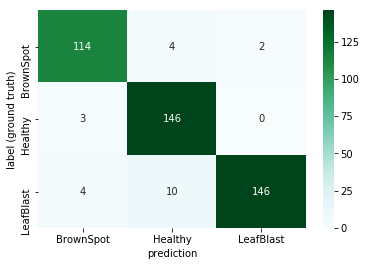


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 256	TRAIN	Loss: 0.17	Correct: 3588/3849(93.22%)
		VALID.:	Loss: 0.52	Correct: 403/429(93.94%)


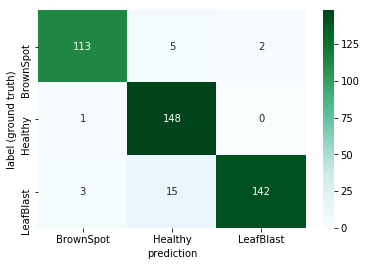


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 257	TRAIN	Loss: 0.04	Correct: 3589/3849(93.24%)
		VALID.:	Loss: 0.31	Correct: 398/429(92.77%)


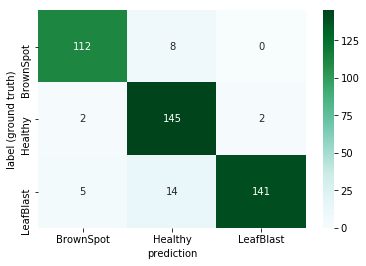


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 258	TRAIN	Loss: 0.11	Correct: 3570/3849(92.75%)
		VALID.:	Loss: 0.26	Correct: 400/429(93.24%)


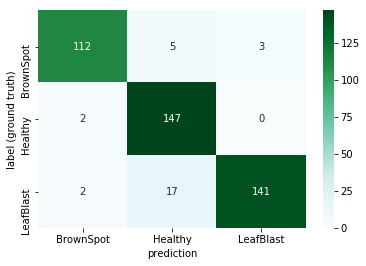


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 259	TRAIN	Loss: 0.29	Correct: 3587/3849(93.19%)
		VALID.:	Loss: 0.14	Correct: 406/429(94.64%)


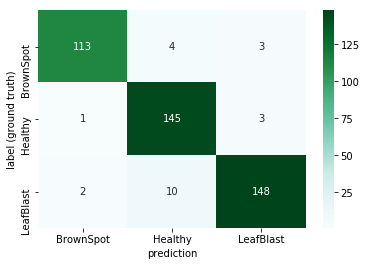


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 260	TRAIN	Loss: 0.07	Correct: 3586/3849(93.17%)
		VALID.:	Loss: 0.18	Correct: 404/429(94.17%)


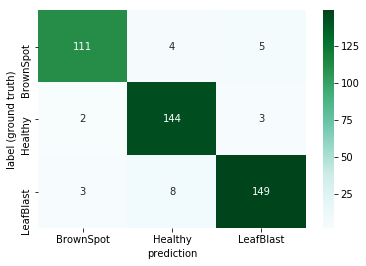


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 261	TRAIN	Loss: 0.11	Correct: 3576/3849(92.91%)
		VALID.:	Loss: 0.21	Correct: 395/429(92.07%)


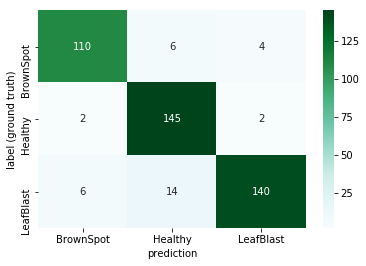


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 262	TRAIN	Loss: 0.59	Correct: 3574/3849(92.86%)
		VALID.:	Loss: 0.34	Correct: 404/429(94.17%)


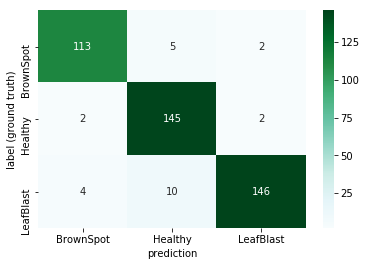


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 263	TRAIN	Loss: 0.59	Correct: 3591/3849(93.3%)
		VALID.:	Loss: 0.04	Correct: 400/429(93.24%)


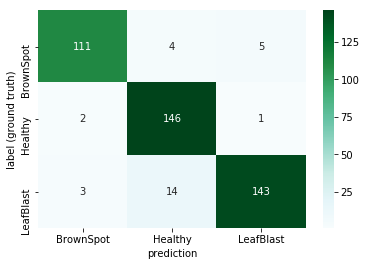


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 264	TRAIN	Loss: 0.09	Correct: 3619/3849(94.02%)
		VALID.:	Loss: 0.3	Correct: 398/429(92.77%)


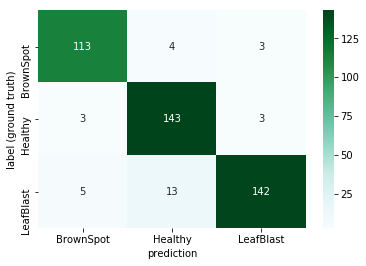


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 265	TRAIN	Loss: 0.03	Correct: 3577/3849(92.93%)
		VALID.:	Loss: 0.18	Correct: 400/429(93.24%)


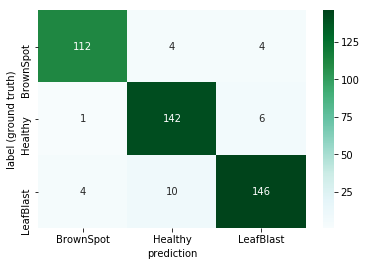


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 266	TRAIN	Loss: 0.11	Correct: 3581/3849(93.04%)
		VALID.:	Loss: 0.22	Correct: 398/429(92.77%)


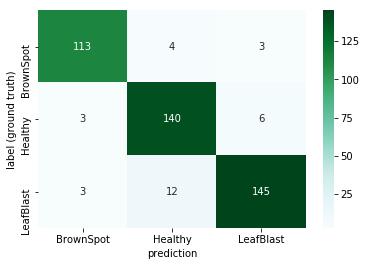


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 267	TRAIN	Loss: 0.06	Correct: 3589/3849(93.24%)
		VALID.:	Loss: 0.3	Correct: 405/429(94.41%)


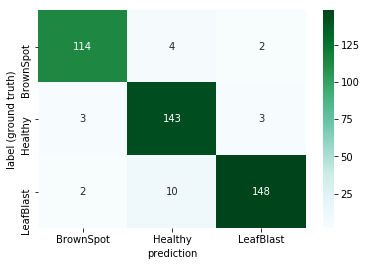


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 268	TRAIN	Loss: 0.43	Correct: 3568/3849(92.7%)
		VALID.:	Loss: 0.14	Correct: 399/429(93.01%)


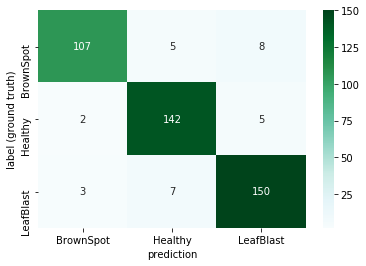


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 269	TRAIN	Loss: 0.16	Correct: 3614/3849(93.89%)
		VALID.:	Loss: 0.18	Correct: 399/429(93.01%)


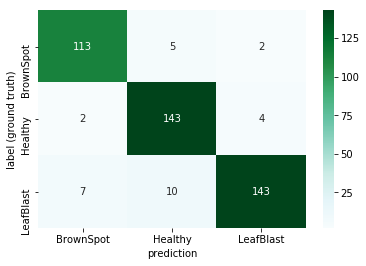


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 270	TRAIN	Loss: 0.12	Correct: 3583/3849(93.09%)
		VALID.:	Loss: 0.06	Correct: 403/429(93.94%)


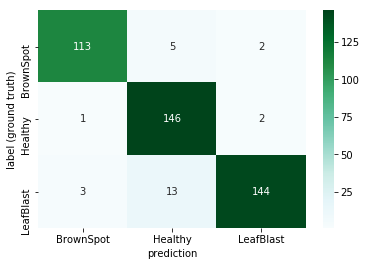


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 271	TRAIN	Loss: 0.27	Correct: 3592/3849(93.32%)
		VALID.:	Loss: 0.07	Correct: 402/429(93.71%)


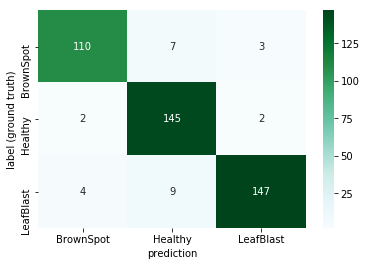


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 272	TRAIN	Loss: 0.52	Correct: 3601/3849(93.56%)
		VALID.:	Loss: 0.12	Correct: 392/429(91.38%)


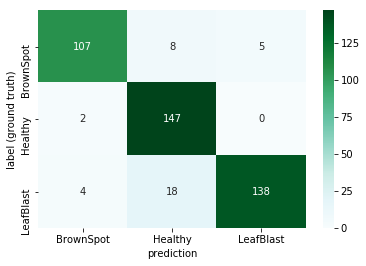


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)
---- batch: 200(384)
---- batch: 300(384)
Epoch: 273	TRAIN	Loss: 0.16	Correct: 3605/3849(93.66%)
		VALID.:	Loss: 0.11	Correct: 404/429(94.17%)


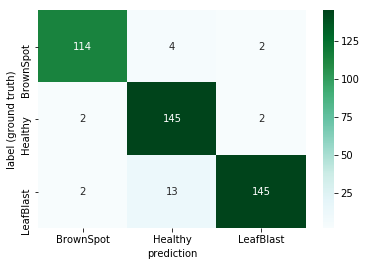


----------------------------------------

---- batch: 0(384)
---- batch: 100(384)


KeyboardInterrupt: 

In [38]:
best_model_prefix = ['']

train(model_googlenet, criterion, optimizer,
      train_loader, valid_loader, 
      n_epoch=300, device=DEVICE,
      out_train_losses=train_losses,
      out_valid_losses=valid_losses,
      out_train_corrects=train_corrects,
      out_valid_corrects=valid_corrects,
      out_best_model_prefix=best_model_prefix,
      prefix='googlenet')

Validation accuracy: 94.87 %


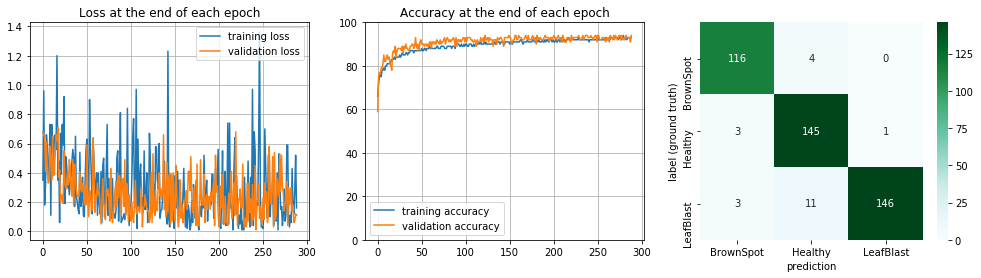

In [39]:
best_model_googlenet = copy.deepcopy(model_googlenet)
restore_progress(best_model_googlenet, optimizer,
                 [], [], [], [],
                 best_model_prefix[0], 'progress')

plot_train_report(best_model_googlenet, 
                  train_loader, valid_loader,
                  train_losses, valid_losses, train_corrects, valid_corrects,
                  DEVICE)

### Save Best to Prod

In [14]:
best_model_path = ''

In [25]:
from torchvision.models import GoogLeNet

state = torch.load(best_model_path)
model_state = state['model_state']

model_best = GoogLeNet(transform_input=True, 
                       aux_logits=False, 
                       init_weights=False)
n_inputs = model_best.fc.in_features
model_best.fc = nn.Linear(n_inputs, 3)
model_best.load_state_dict(model_state)

model_best = model_best.to(DEVICE)

New Eval accuracy: 100.0 %


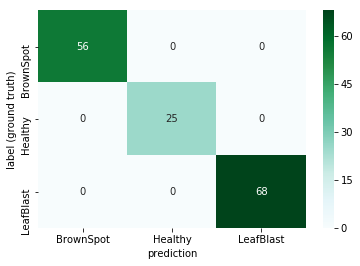

In [26]:
valid_new_loader = DataLoader(datasets.ImageFolder(data_new_folder, transform=img_transforms['valid']), 
                              batch_size=100,
                              pin_memory=False,
                              num_workers=4)

evaluate_model(model_best, valid_new_loader, DEVICE, 'New Eval')

In [33]:
save_path = ''

state = {
    'version': '0.1',
    'model_state': model_best.state_dict(),
    'preprocess': img_transforms['valid']
}
torch.save(state, save_path) 